# Quadruple-Well Potential System: Kernel EDMD + LAWGD

## Objective
1. Define 2D quadruple-well potential system V(x,y) = (x²-1)² + (y²-1)²
2. Compute corresponding Boltzmann stationary distribution π(x) ∝ exp(-V(x))
3. Learn Langevin generator using Kernel EDMD
4. Use LAWGD to transport particles from outside wells into the four potential wells

## Theoretical Background
- Langevin dynamics: dX = -∇V(X)dt + √(2)dW
- Stationary distribution: π(x) ∝ exp(-V(x))
- Four potential wells located at (±1, ±1)
- Goal: Learn generator from data, transport particles to stationary distribution

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd, eig
import time

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Four-Well Potential Function

We define a 2D four-well potential:
$$V(x, y) = (x^2 - 1)^2 + (y^2 - 1)^2$$

This potential has four local minima:
- Well 1: (x, y) ≈ (-1, -1)
- Well 2: (x, y) ≈ (1, -1)
- Well 3: (x, y) ≈ (-1, 1)
- Well 4: (x, y) ≈ (1, 1)
- Central saddle point: (0, 0)

In [2]:
class FourWellPotential:
    """
    2D Four-Well Potential System
    
    Potential function: V(x, y) = a*(x^2 - 1)^2 + b*(y^2 - 1)^2
    
    This creates four potential wells at approximately (±1, ±1)
    
    Parameters:
        a: Controls double-well depth in x-direction (default 1.0)
        b: Controls double-well depth in y-direction (default 1.0)
        temperature: Temperature parameter (default 1.0), affects Boltzmann distribution width
    """
    
    def __init__(self, a=1.0, b=1.0, temperature=1.0):
        self.a = a
        self.b = b
        self.T = temperature  # Temperature (kT in units where k_B = 1)
        self._Z = None  # Partition function cache
        
    def V(self, x, y=None):
        """
        Compute potential energy
        
        Parameters:
            x: If y is None, x is array of shape (n, 2)
               Otherwise x is x-coordinate, y is y-coordinate
        Returns:
            Potential energy value(s)
        """
        if y is None:
            # x is (n, 2) array
            x_coord = x[:, 0] if x.ndim > 1 else x[0]
            y_coord = x[:, 1] if x.ndim > 1 else x[1]
        else:
            x_coord = x
            y_coord = y
            
        return self.a * (x_coord**2 - 1)**2 + self.b * (y_coord**2 - 1)**2
    
    def grad_V(self, X):
        """
        Compute potential gradient ∇V(x, y)
        
        Parameters:
            X: Array of shape (n, 2), each row is a point (x, y)
        Returns:
            Gradient array of shape (n, 2)
        """
        x = X[:, 0]
        y = X[:, 1]
        
        # ∂V/∂x = 4*a*x*(x^2 - 1)
        dV_dx = 4 * self.a * x * (x**2 - 1)
        
        # ∂V/∂y = 4*b*y*(y^2 - 1)
        dV_dy = 4 * self.b * y * (y**2 - 1)
        
        return np.stack([dV_dx, dV_dy], axis=1)
    
    def stationary_density(self, x, y=None, x_range=(-3, 3), y_range=(-3, 3), n_grid=500):
        """
        Compute normalized Boltzmann stationary distribution π(x) = exp(-V(x)/T) / Z
        
        Parameters:
            x, y: Coordinates (can be scalar, array, or grid)
            x_range, y_range: Range for numerical integration to compute Z
            n_grid: Grid size for numerical integration
            
        Returns:
            Normalized density values
        """
        # Compute unnormalized density
        V_val = self.V(x, y)
        unnormalized_density = np.exp(-V_val / self.T)
        
        # Compute partition function Z if not cached
        if self._Z is None:
            x_int = np.linspace(x_range[0], x_range[1], n_grid)
            y_int = np.linspace(y_range[0], y_range[1], n_grid)
            dx = (x_range[1] - x_range[0]) / n_grid
            dy = (y_range[1] - y_range[0]) / n_grid
            X_int, Y_int = np.meshgrid(x_int, y_int)
            V_int = self.V(X_int, Y_int)
            self._Z = np.sum(np.exp(-V_int / self.T)) * dx * dy
        
        return unnormalized_density / self._Z

# Create four-well system instance
potential = FourWellPotential(a=1.0, b=1.0, temperature=1)

print("FQuadruple-well potential system created!")
print(f"Parameters: a={potential.a}, b={potential.b}, T={potential.T}")
print(f"Energy minima locations: (±1, ±1)")
print(f"Minimum energy value: V(1, 1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Saddle point value: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")

FQuadruple-well potential system created!
Parameters: a=1.0, b=1.0, T=1
Energy minima locations: (±1, ±1)
Minimum energy value: V(1, 1) = 0.0000
Saddle point value: V(0, 0) = 2.0000


## Visualize Potential Landscape and Stationary Distribution

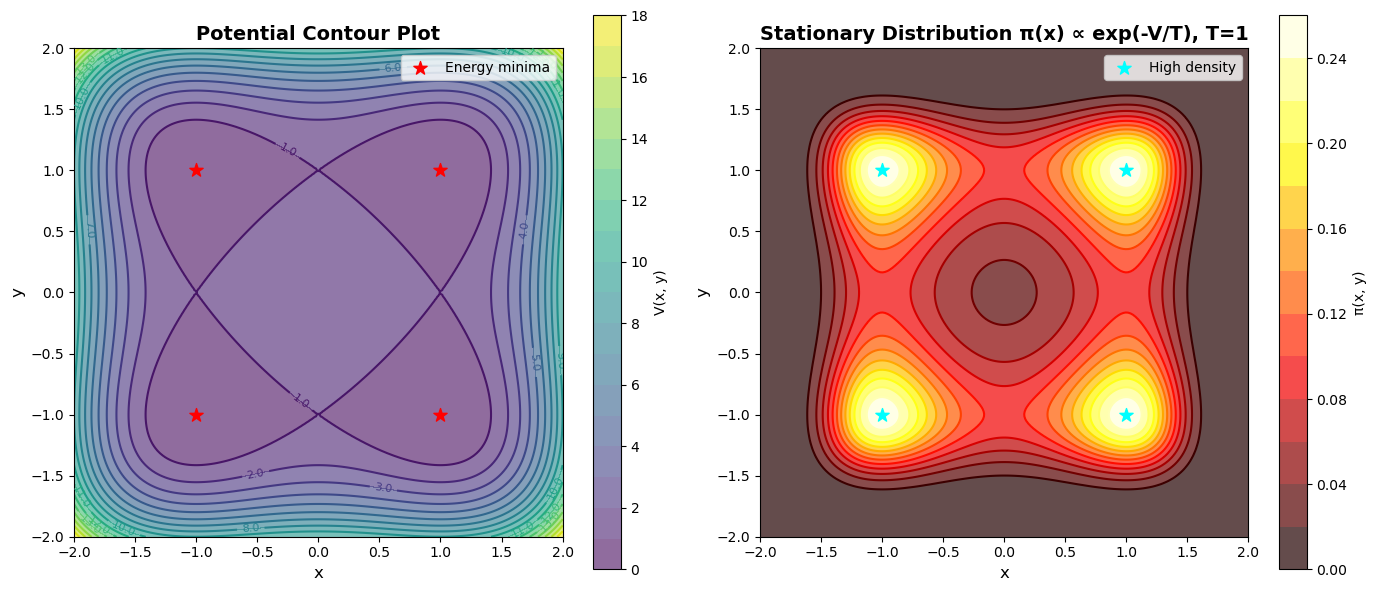


Potential Analysis:
Energy minima: V(±1, ±1) = 0.0000
Central saddle: V(0, 0) = 2.0000
Side saddles: V(±1, 0) = 1.0000
Energy difference: ΔV = 2.0000
Temperature parameter: T = 1

Stationary distribution concentrates around four energy minima!


In [3]:
# Create grid for visualization
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-2, 2, 200)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

# Compute potential and density
V_grid = potential.V(X_grid, Y_grid)
density_grid = potential.stationary_density(X_grid, Y_grid)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Subplot 1: Potential Contour Plot ==========
ax1 = axes[0]
contour = ax1.contour(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', linewidths=1.5)
contourf = ax1.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
ax1.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='red', s=100, marker='*', 
           label='Energy minima', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('Potential Contour Plot', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right')
fig.colorbar(contourf, ax=ax1, label='V(x, y)')

# ========== Subplot 2: Boltzmann Stationary Distribution π(x) ∝ exp(-V/T) ==========
ax2 = axes[1]
contour_density = ax2.contour(X_grid, Y_grid, density_grid, levels=15, 
                              cmap='hot', linewidths=1.5)
contourf_density = ax2.contourf(X_grid, Y_grid, density_grid, levels=15, 
                                cmap='hot', alpha=0.7)
ax2.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='cyan', s=100, marker='*', 
           label='High density', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'Stationary Distribution π(x) ∝ exp(-V/T), T={potential.T}', 
             fontsize=14, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')
fig.colorbar(contourf_density, ax=ax2, label='π(x, y)')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Potential Analysis:")
print("="*60)
print(f"Energy minima: V(±1, ±1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Central saddle: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")
print(f"Side saddles: V(±1, 0) = {potential.V(np.array([[1.0, 0.0]]))[0]:.4f}")
print(f"Energy difference: ΔV = {potential.V(np.array([[0.0, 0.0]]))[0] - potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Temperature parameter: T = {potential.T}")
print(f"\nStationary distribution concentrates around four energy minima!")
print("="*60)

## Verify Stationary Distribution Normalization

Check that the stationary distribution is properly normalized (∫ π(x) dx = 1)

In [4]:
# Verify normalization of stationary distribution
# Numerically integrate π(x) over the entire domain

# Use a fine grid for accurate integration
x_int = np.linspace(-3, 3, 300)
y_int = np.linspace(-3, 3, 300)
X_int, Y_int = np.meshgrid(x_int, y_int)
dx = x_int[1] - x_int[0]
dy = y_int[1] - y_int[0]

# Compute density on integration grid
density_int = potential.stationary_density(X_int, Y_int)

# Numerical integration using trapezoidal rule
integral = np.sum(density_int) * dx * dy

print("="*60)
print("Normalization Verification:")
print("="*60)
print(f"Numerical integral of π(x) over domain: {integral:.6f}")
print(f"Expected value: 1.0")
print(f"Relative error: {abs(integral - 1.0):.2e}")
print("="*60)

if abs(integral - 1.0) < 0.01:
    print("✓ Distribution is properly normalized!")
else:
    print("⚠ Warning: Distribution normalization may be inaccurate")
    print("  (This could be due to finite integration domain)")
print("="*60)

Normalization Verification:
Numerical integral of π(x) over domain: 1.004012
Expected value: 1.0
Relative error: 4.01e-03
✓ Distribution is properly normalized!


## Generate Training Data: (X_tar, X_tar_next)

Sample X_tar from stationary distribution π(x), then evolve to X_tar_next using Langevin dynamics:
$$dX = -\nabla V(X)dt + \sqrt{2}dW$$

In [5]:
# ============================================================
# Step 1: Generate Time Series Trajectory using Langevin Dynamics
# ============================================================

def generate_langevin_trajectory(potential, n_samples=2500, dt=0.1, n_substeps=10, burnin=1000):
    """
    Generate a single long trajectory from Langevin dynamics
    
    SDE: dX = -∇V(X)dt + √(2)dW
    
    Parameters:
        potential: FourWellPotential instance
        n_samples: Number of trajectory points to generate
        dt: Time step between saved points
        n_substeps: Number of sub-steps for numerical stability per dt
        burnin: Number of initial steps to discard (thermalization)
    
    Returns:
        trajectory: Array of shape (n_samples, 2) - consecutive time series points
    """
    # Initialize at a random position
    X_curr = np.random.randn(2) * 0.5
    
    trajectory = []
    n_total = burnin + n_samples
    dt_sub = dt / n_substeps
    
    print(f"Generating Langevin trajectory:")
    print(f"  - Total time steps: {n_total}")
    print(f"  - Burnin steps: {burnin}")
    print(f"  - Trajectory length: {n_samples}")
    print(f"  - dt = {dt}, sub-steps = {n_substeps}, dt_sub = {dt_sub:.6f}")
    
    for i in range(n_total):
        # Evolve for one time step (with n_substeps)
        for _ in range(n_substeps):
            # Drift term: -∇V(X)
            grad_V = potential.grad_V(X_curr.reshape(1, -1))
            drift = -grad_V[0]
            
            # Diffusion term: √(2 * dt_sub) * Gaussian noise
            noise = np.sqrt(2.0 * dt_sub) * np.random.randn(2)
            
            # Euler-Maruyama update
            X_curr = X_curr + drift * dt_sub + noise
        
        # Store trajectory point after burnin
        if i >= burnin:
            trajectory.append(X_curr.copy())
        
        # Progress indicator
        if (i + 1) % 500 == 0:
            print(f"  Progress: {i+1}/{n_total} steps", end='\r')
    
    print(f"\n  Trajectory generation complete!")
    return np.array(trajectory)

# Generate trajectory data
n_samples = 2500
dt = 0.1  # Time step between consecutive points
n_substeps = 10  # Numerical stability
burnin = 1000  # Thermalization period

print("="*60)
print("Generating X_tar as a time series trajectory...")
print("="*60)
X_tar = generate_langevin_trajectory(potential, n_samples=n_samples, dt=dt, 
                                     n_substeps=n_substeps, burnin=burnin)
print(f"\nX_tar shape: {X_tar.shape}")
print(f"X_tar range: x ∈ [{X_tar[:, 0].min():.2f}, {X_tar[:, 0].max():.2f}], "
      f"y ∈ [{X_tar[:, 1].min():.2f}, {X_tar[:, 1].max():.2f}]")
print(f"\n✓ Data type: CONSECUTIVE TIME SERIES (not i.i.d. samples)")
print(f"  X_tar[i] → X_tar[i+1] are temporally correlated")
print("="*60)

Generating X_tar as a time series trajectory...
Generating Langevin trajectory:
  - Total time steps: 3500
  - Burnin steps: 1000
  - Trajectory length: 2500
  - dt = 0.1, sub-steps = 10, dt_sub = 0.010000
  Progress: 3500/3500 steps
  Trajectory generation complete!

X_tar shape: (2500, 2)
X_tar range: x ∈ [-1.78, 1.90], y ∈ [-1.83, 1.81]

✓ Data type: CONSECUTIVE TIME SERIES (not i.i.d. samples)
  X_tar[i] → X_tar[i+1] are temporally correlated
  Progress: 3500/3500 steps
  Trajectory generation complete!

X_tar shape: (2500, 2)
X_tar range: x ∈ [-1.78, 1.90], y ∈ [-1.83, 1.81]

✓ Data type: CONSECUTIVE TIME SERIES (not i.i.d. samples)
  X_tar[i] → X_tar[i+1] are temporally correlated


In [6]:
# ============================================================
# Step 2: Create X_tar_next from consecutive trajectory points
# ============================================================

print("="*60)
print("Creating training pairs (X_tar, X_tar_next) from trajectory...")
print("="*60)
print(f"Method: Consecutive time series points")
print(f"  X_tar[i] at time t_i")
print(f"  X_tar_next[i] at time t_(i+1) = t_i + dt")

# Simply shift the trajectory by one time step
X_tar_next = X_tar[1:].copy()  # Points from t=1 to t=2500
X_tar = X_tar[:-1].copy()      # Points from t=0 to t=2499

print(f"\nX_tar shape: {X_tar.shape}")
print(f"X_tar_next shape: {X_tar_next.shape}")
print(f"\nTraining pairs: {X_tar.shape[0]}")
print(f"Time lag: dt = {dt}")
print(f"\n✓ Each pair (X_tar[i], X_tar_next[i]) represents:")
print(f"  one step evolution under Langevin dynamics")
print("="*60)

Creating training pairs (X_tar, X_tar_next) from trajectory...
Method: Consecutive time series points
  X_tar[i] at time t_i
  X_tar_next[i] at time t_(i+1) = t_i + dt

X_tar shape: (2499, 2)
X_tar_next shape: (2499, 2)

Training pairs: 2499
Time lag: dt = 0.1

✓ Each pair (X_tar[i], X_tar_next[i]) represents:
  one step evolution under Langevin dynamics


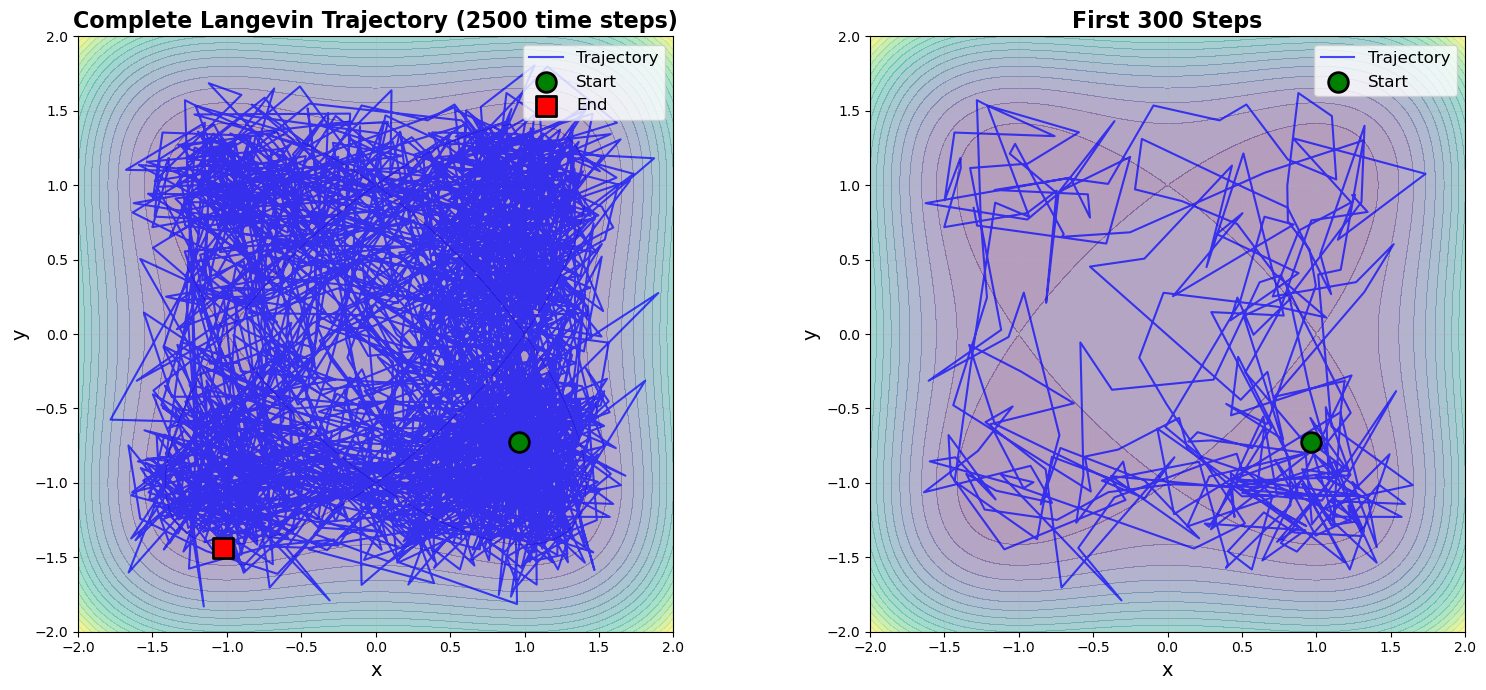


Time Series Trajectory
Total trajectory length: 2500 time steps
Time interval: dt = 0.1
Total simulation time: 249.9 time units


In [7]:
# ============================================================
# Visualize Time Series Trajectory
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ========== Subplot 1: Complete Trajectory ==========
ax1 = axes[0]

# Plot potential contour as background
contourf1 = ax1.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.4)

# Plot the trajectory as a simple blue line
ax1.plot(X_tar[:, 0], X_tar[:, 1], 'b-', linewidth=1.5, alpha=0.7, label='Trajectory')

# Mark start and end points
ax1.scatter(X_tar[0, 0], X_tar[0, 1], c='green', s=200, marker='o', 
           edgecolors='black', linewidth=2, label='Start', zorder=10)
ax1.scatter(X_tar[-1, 0], X_tar[-1, 1], c='red', s=200, marker='s', 
           edgecolors='black', linewidth=2, label='End', zorder=10)

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14)
ax1.set_title(f'Complete Langevin Trajectory ({len(X_tar)+1} time steps)', fontsize=16, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)

# ========== Subplot 2: First 300 Steps ==========
ax2 = axes[1]
n_zoom = min(300, len(X_tar))

# Plot potential contour as background
contourf2 = ax2.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.4)

# Plot the trajectory as a simple blue line (first 300 steps)
ax2.plot(X_tar[:n_zoom, 0], X_tar[:n_zoom, 1], 'b-', linewidth=1.5, alpha=0.7, label='Trajectory')

# Mark start point only
ax2.scatter(X_tar[0, 0], X_tar[0, 1], c='green', s=200, marker='o', 
           edgecolors='black', linewidth=2, label='Start', zorder=10)

ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14)
ax2.set_title(f'First {n_zoom} Steps', fontsize=16, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Time Series Trajectory")
print("="*60)
print(f"Total trajectory length: {len(X_tar)+1} time steps")
print(f"Time interval: dt = {dt}")
print(f"Total simulation time: {len(X_tar) * dt:.1f} time units")
print("="*60)

In [8]:
# # ============================================================
# # Polynomial EDMD: Extended Dynamic Mode Decomposition
# # ============================================================

# # Preconditions
# if 'X_tar' not in globals() or 'X_tar_next' not in globals():
#     raise RuntimeError('X_tar and X_tar_next must be computed before running EDMD (polynomial).')

# n = X_tar.shape[0]

# # Step 1: Build polynomial basis functions
# degree = 4

# def monomial_exponents_2d(deg: int):
#     exps = []
#     for total in range(deg + 1):
#         for i in range(total + 1):
#             exps.append((i, total - i))
#     return exps

# exps = monomial_exponents_2d(degree)
# m_dict = len(exps)

# # Optional feature scaling for numerical stability
# Z_all = np.vstack([X_tar, X_tar_next])
# scale = 1.0  # No scaling for this example
# X0 = X_tar / scale
# Y0 = X_tar_next / scale

# # Feature map Φ(X)
# def phi_poly(X: np.ndarray) -> np.ndarray:
#     N = X.shape[0]
#     Phi = np.empty((N, m_dict), dtype=float)
#     x = X[:, 0]
#     y = X[:, 1]
#     for k, (i, j) in enumerate(exps):
#         if i == 0 and j == 0:
#             Phi[:, k] = 1.0
#         elif i == 0:
#             Phi[:, k] = y ** j
#         elif j == 0:
#             Phi[:, k] = x ** i
#         else:
#             Phi[:, k] = (x ** i) * (y ** j)
#     return Phi

# Phi = phi_poly(X0)
# Phi_next = phi_poly(Y0)
# N = Phi.shape[0]

# # Step 2: Build EDMD matrices
# G_edmd = (Phi.T @ Phi) / N
# A_edmd = (Phi.T @ Phi_next) / N

# # Step 3: Compute Koopman operator
# reg = 1e-10
# I = np.eye(G_edmd.shape[0])
# K_edmd = np.linalg.solve(G_edmd + reg * I, A_edmd)

# # Step 4: Compute eigenvalues
# eigenvalues_edmd = np.linalg.eigvals(K_edmd)

# # Step 5: Construct generator eigenvalues and inverse weights
# # Extract real part of eigenvalues (ignore imaginary part)
# lambda_ns_edmd = eigenvalues_edmd.real

# # Construct generator eigenvalues: λ_gen = (λ_K - 1) / dt
# lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt

# # Build inverse generator weights (for LAWGD)
# tol_edmd = 1e-6
# lambda_ns_inv_edmd = np.zeros_like(lambda_ns_edmd)
# mask_edmd = lambda_ns_edmd >= tol_edmd
# lambda_ns_inv_edmd[mask_edmd] = 1.0 / (lambda_ns_edmd[mask_edmd] + 0.001)

# # Store results for LAWGD
# eigvals_K_edmd = lambda_ns_edmd.copy()
# lambda_gen_full_edmd = lambda_gen_edmd.copy()

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_edmd.real, eigenvalues_edmd.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Polynomial EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_edmd)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_edmd)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_edmd) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_real_edmd = np.sort(eigenvalues_edmd.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_edmd):
#     print(f"{i+1:3d}. {real_part:+.6f}")

In [9]:
# from deeptime.data import quadruple_well
# import matplotlib.pyplot as plt

# h = 1e-3 # step size of the Euler-Maruyama integrator
# n_steps = 10000 # number of steps, the lag time is thus tau = nSteps*h = 10
# x0 = np.zeros((1, 2)) # inital condition
# n = 10000 # number of evaluations of the  discretized dynamical system with lag time tau

# f = quadruple_well(n_steps=n_steps)  # loading the model
# traj = f.trajectory(x0, n, seed=42)

# m = 2500 # number of training data points
# X = np.random.uniform(-2, 2, size=(2500, 2)) # training data
# # X = 4*np.random.rand(2, m)-2
# Y = f(X, seed=42, n_jobs=1) # training data mapped forward by the dynamical system

# from deeptime.kernels import GaussianKernel
# from deeptime.decomposition import KernelEDMD

# # ============================================================
# # Kernel Definition (GaussianKernel)
# # ============================================================
# # Deeptime's GaussianKernel(sigma) defines:
# #   k(x, y) = exp(-||x - y||² / (2 * sigma²))
# # 
# # This is equivalent to RBF kernel with bandwidth epsilon = sigma²
# # So sigma=1 means epsilon=1
# # ============================================================

# sigma = 1  # kernel bandwidth parameter
# kernel = GaussianKernel(sigma)

# # ============================================================
# # Compute ALL eigenvalues using full eigendecomposition
# # ============================================================
# # Instead of only computing n_eigs=6, we'll compute ALL eigenvalues
# # by manually constructing the Koopman operator matrix

# def rbf_kernel_matrix(X1, X2, sigma):
#     """Compute RBF kernel matrix: k(x,y) = exp(-||x-y||²/(2*sigma²))"""
#     # Compute squared distances
#     X1_sq = np.sum(X1**2, axis=1, keepdims=True)  # (n1, 1)
#     X2_sq = np.sum(X2**2, axis=1, keepdims=True)  # (n2, 1)
#     sq_dists = X1_sq + X2_sq.T - 2 * (X1 @ X2.T)  # (n1, n2)
    
#     # Apply RBF kernel
#     K = np.exp(-sq_dists / (2 * sigma**2))
#     return K

# K_XX = rbf_kernel_matrix(X, X, sigma)  # shape: (2500, 2500)
# K_XY = rbf_kernel_matrix(X, Y, sigma)  # shape: (2500, 2500)

# # Construct Koopman operator K = K_XY @ (K_XX + epsilon*I)^{-1}
# epsilon_reg = 1e-3  # regularization parameter
# I_mat = np.eye(K_XX.shape[0])
# K_koopman = K_XY @ np.linalg.inv(K_XX + epsilon_reg * I_mat)

# # Compute ALL eigenvalues
# eigenvalues_all, eigenvectors_all = np.linalg.eig(K_koopman)

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_all.real, eigenvalues_all.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Deeptime Kernel EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_all)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_all)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_all) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_idx = np.argsort(np.abs(eigenvalues_all))[::-1]
# sorted_real_deeptime = np.sort(eigenvalues_all.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_deeptime):
#     print(f"{i+1:3d}. {real_part:+.6f}")

In [10]:
# # ============================================================
# # Kernel EDMD: Extended Dynamic Mode Decomposition with RBF Kernel
# # ============================================================

# # Preconditions
# if 'X_tar' not in globals() or 'X_tar_next' not in globals():
#     raise RuntimeError('X_tar and X_tar_next must be computed before running Kernel EDMD.')

# n = X_tar.shape[0]

# # Step 1: Build Gaussian RBF kernel matrices
# # Compute bandwidth epsilon using median heuristic
# sq_tar = np.sum(X_tar ** 2, axis=1)
# H_tar = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
# epsilon_kedmd = 0.5 * np.median(H_tar) / np.log(n + 1)

# def rbf_kernel(X, Y, eps):
#     """Gaussian RBF kernel k(x,y) = exp(-||x-y||²/(2ε))"""
#     sq_x = np.sum(X ** 2, axis=1)
#     sq_y = np.sum(Y ** 2, axis=1)
#     H = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
#     return np.exp(-H / (2 * eps))

# # Kernel matrices: K_xx = K(X_tar, X_tar), K_xy = K(X_tar, X_tar_next)
# K_xx = rbf_kernel(X_tar, X_tar, 1)
# K_xy = rbf_kernel(X_tar, X_tar_next, 1)

# # Step 2: Compute Koopman operator via kernel matrices
# # K = K_xy @ (K_xx + γI)^{-1}
# reg_kedmd = 1e-3  # Use strong regularization like deeptime
# I_kedmd = np.eye(n)
# K_kedmd = K_xy @ np.linalg.inv(K_xx + reg_kedmd * I_kedmd)

# # Step 3: Compute eigenvalues and eigenvectors
# eigenvalues_kedmd, eigenvectors_kedmd = np.linalg.eig(K_kedmd)

# # Step 4: Construct generator eigenvalues and inverse weights
# # Extract real part of eigenvalues (ignore imaginary part)
# lambda_ns_kedmd = eigenvalues_kedmd.real

# # Construct generator eigenvalues: λ_gen = (λ_K - 1) / dt
# lambda_gen_kedmd = (lambda_ns_kedmd - 1.0) / dt

# # Build inverse generator weights (for LAWGD)
# tol_kedmd = 1e-6
# lambda_ns_inv_kedmd = np.zeros_like(lambda_ns_kedmd)
# mask_kedmd = lambda_ns_kedmd >= tol_kedmd
# lambda_ns_inv_kedmd[mask_kedmd] = 1.0 / (lambda_ns_kedmd[mask_kedmd] + 0.001)

# # Store results for LAWGD
# eigvals_K_kedmd = lambda_ns_kedmd.copy()
# eigvecs_K_kedmd = eigenvectors_kedmd.copy()
# lambda_gen_full_kedmd = lambda_gen_kedmd.copy()

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_kedmd.real, eigenvalues_kedmd.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Kernel EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_kedmd)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_kedmd)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_kedmd) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_real_kedmd = np.sort(eigenvalues_kedmd.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_kedmd):
#     print(f"{i+1:3d}. {real_part:+.6f}")

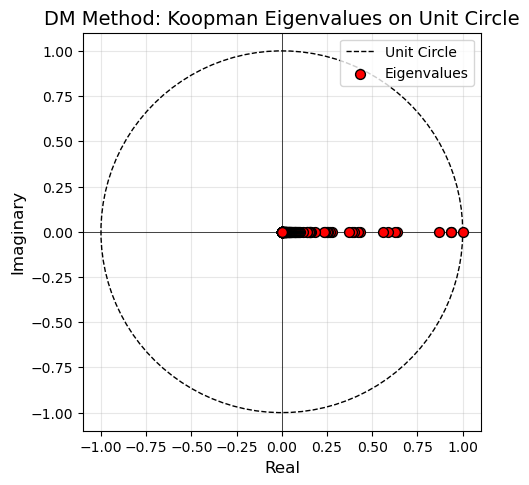

Number of eigenvalues: 2499
Max magnitude: 1.0016
Eigenvalues outside unit circle: 1

Eigenvalues (Real part, sorted from large to small):
  1. +1.001614
  2. +0.933839
  3. +0.933140
  4. +0.871576
  5. +0.636071
  6. +0.628063
  7. +0.584955
  8. +0.557791
  9. +0.433860
 10. +0.422705
 11. +0.398665
 12. +0.387397
 13. +0.371486
 14. +0.274656
 15. +0.268123
 16. +0.256246
 17. +0.250178
 18. +0.239442
 19. +0.231188
 20. +0.181726
 21. +0.161791
 22. +0.156582
 23. +0.153112
 24. +0.149152
 25. +0.141514
 26. +0.138302
 27. +0.115317
 28. +0.099805
 29. +0.096224
 30. +0.089073
 31. +0.086279
 32. +0.080895
 33. +0.075197
 34. +0.071837
 35. +0.069704
 36. +0.063410
 37. +0.056864
 38. +0.050282
 39. +0.047987
 40. +0.046013
 41. +0.044231
 42. +0.040798
 43. +0.040251
 44. +0.037639
 45. +0.036183
 46. +0.032798
 47. +0.031139
 48. +0.026774
 49. +0.025329
 50. +0.024178
 51. +0.022541
 52. +0.021877
 53. +0.020741
 54. +0.019543
 55. +0.018327
 56. +0.016613
 57. +0.015956
 58. +

In [11]:
# ============================================================
# DM Method: Diffusion Maps for Langevin Generator Construction
# ============================================================

# Preconditions
if 'X_tar' not in globals() or 'X_tar_next' not in globals():
    raise RuntimeError('X_tar and X_tar_next must be computed before running DM method.')

n = X_tar.shape[0]

# Step 1: Build Gaussian kernel
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / np.log(n + 1)

def ker(X):
    """Gaussian kernel k(x,y) = exp(-||x-y||²/(2ε))"""
    sq = np.sum(X ** 2, axis=1)
    return np.exp(-(sq[:, None] + sq[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)

# Step 2: Anisotropic normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

# Step 3: Random-walk symmetric normalization
rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])

# Step 4: SVD to get spectrum
phi, s, _ = svd(rw_kernel)
lambda_ns = s  # Singular values (eigenvalues of symmetric matrix)

# Step 5: Construct generator eigenvalues
lambda_gen_dm = (lambda_ns - 1.0) / epsilon

# Step 6: Build inverse generator weights (for LAWGD)
tol = 1e-6
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + 0.001)

# Store results for LAWGD
eigvals_K_dm = lambda_ns.copy()
eigvecs_K_dm = phi.copy()
lambda_gen_full = lambda_gen_dm.copy()

# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

fig, ax = plt.subplots(figsize=(5, 5))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# Plot eigenvalues
ax.scatter(eigvals_K_dm.real, eigvals_K_dm.imag, c='red', s=50, marker='o', 
           edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real', fontsize=12)
ax.set_ylabel('Imaginary', fontsize=12)
ax.set_title('DM Method: Koopman Eigenvalues on Unit Circle', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Number of eigenvalues: {len(eigvals_K_dm)}")
print(f"Max magnitude: {np.max(np.abs(eigvals_K_dm)):.4f}")
print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigvals_K_dm) > 1)}")

# Sort eigenvalues by real part (descending order)
sorted_real_dm = np.sort(eigvals_K_dm.real)[::-1]

print("\n" + "="*50)
print("Eigenvalues (Real part, sorted from large to small):")
print("="*50)
for i, real_part in enumerate(sorted_real_dm):
    print(f"{i+1:3d}. {real_part:+.6f}")


Step 1: Generate initial particles outside wells...
Generating initialization trajectory (short)...
Generating Langevin trajectory:
  - Total time steps: 1000
  - Burnin steps: 500
  - Trajectory length: 500
  - dt = 0.1, sub-steps = 10, dt_sub = 0.010000
  Progress: 1000/1000 steps
  Trajectory generation complete!
Initial trajectory points: 500
Particles outside wells (r > 0.4): 345
Particles removed (inside wells): 155

Step 2: Preparing LAWGD with DM Koopman spectrum...

  Mode selection strategy: use all valid modes
    - Total eigenvalues: 2499
    - Skipping first 1 eigenvalues (constant modes)
    - Eigenvalue threshold: λ > 0.01 (exclude near-zero)
    - Skipped due to threshold: 2436
    - **Using 62 valid modes** (modes 2 to 63)

  Selected eigenvalues for LAWGD:
    Mode 2: λ = 0.933839, λ_gen = -0.42
    Mode 3: λ = 0.933140, λ_gen = -0.43
    Mode 4: λ = 0.871576, λ_gen = -0.82
    Mode 5: λ = 0.636071, λ_gen = -2.33
    Mode 6: λ = 0.628063, λ_gen = -2.38
    Mode 7: λ =

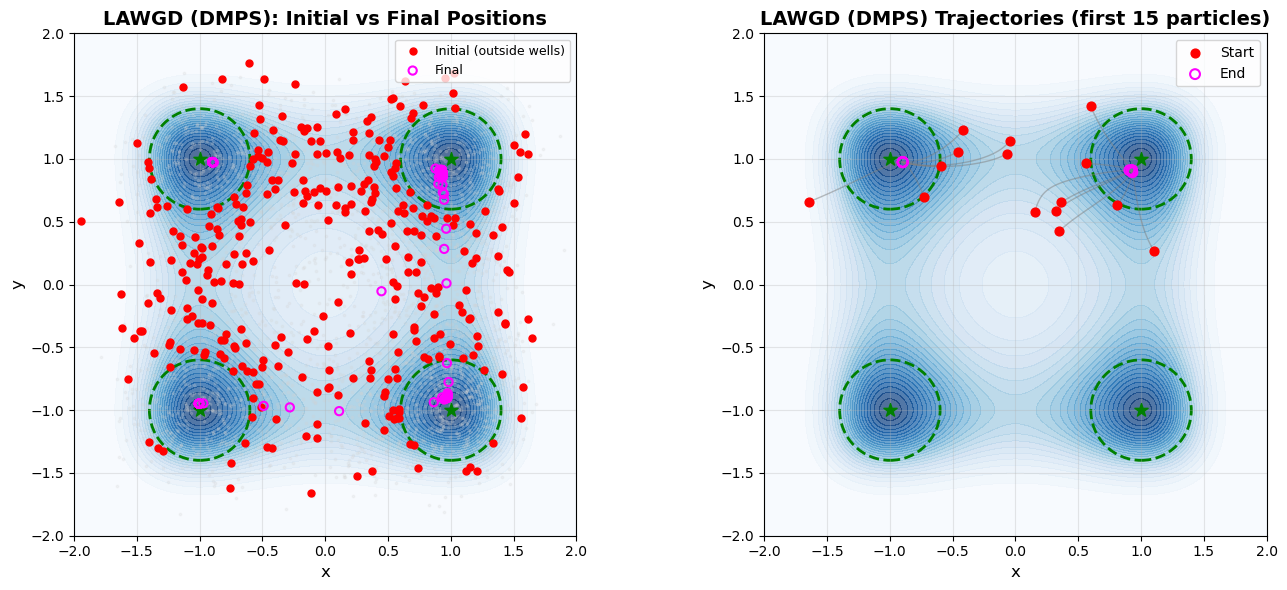

In [12]:
# ============================================================
# LAWGD: Langevin-Adjusted Wasserstein Gradient Descent (DMPS)
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print("Step 1: Generate initial particles outside wells...")
print("="*60)

# Step 1: Generate initial particles from a short trajectory segment
# We'll use a segment from the END of the time series trajectory (outside well regions)
n_init_particles = 500

# Generate a fresh trajectory for initialization
print("Generating initialization trajectory (short)...")
X_init_traj = generate_langevin_trajectory(potential, n_samples=n_init_particles, 
                                           dt=0.1, n_substeps=10, burnin=500)

# Step 2: Remove points within radius of well centers (±1, ±1)
well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
well_radius = 0.4

# Compute distances to all four wells
dist_to_wells = np.array([np.linalg.norm(X_init_traj - center, axis=1) for center in well_centers])
min_dist_to_wells = np.min(dist_to_wells, axis=0)

# Keep only points outside wells
mask_outside = min_dist_to_wells > well_radius
X_lawgd_init = X_init_traj[mask_outside]

print(f"Initial trajectory points: {n_init_particles}")
print(f"Particles outside wells (r > {well_radius}): {X_lawgd_init.shape[0]}")
print(f"Particles removed (inside wells): {n_init_particles - X_lawgd_init.shape[0]}")

# Step 2: Prepare LAWGD using DM-based Koopman spectrum
print(f"\n{'='*60}")
print("Step 2: Preparing LAWGD with DM Koopman spectrum...")
print(f"{'='*60}")

# Use DM method results (computed in previous cell)
eigvals_K = eigvals_K_dm.copy()
eigvecs_K = eigvecs_K_dm.copy()
lambda_gen = lambda_gen_full.copy()

# Mode selection strategy: use all valid modes
n_skip = 1  # Skip first 1 eigenvalues (constant modes)
eig_threshold = 0.01  # Threshold for valid eigenvalues (exclude near-zero eigenvalues)

# Find valid eigenvalues: skip first n_skip, and keep those > threshold
eigvals_after_skip = eigvals_K[n_skip:]
valid_mask = eigvals_after_skip.real > eig_threshold
n_valid = np.sum(valid_mask)

# Use ALL valid modes
k_modes = n_valid
mode_start = n_skip
mode_end = mode_start + k_modes

print(f"\n  Mode selection strategy: use all valid modes")
print(f"    - Total eigenvalues: {len(eigvals_K)}")
print(f"    - Skipping first {n_skip} eigenvalues (constant modes)")
print(f"    - Eigenvalue threshold: λ > {eig_threshold} (exclude near-zero)")
print(f"    - Skipped due to threshold: {len(eigvals_K) - n_skip - k_modes}")
print(f"    - **Using {k_modes} valid modes** (modes {mode_start+1} to {mode_end})")
print(f"\n  Selected eigenvalues for LAWGD:")
for i in range(mode_start, mode_end):
    print(f"    Mode {i+1}: λ = {eigvals_K[i].real:.6f}, λ_gen = {lambda_gen[i].real:.2f}")

# Build inverse generator weights for selected modes
lambda_gen_selected = lambda_gen[mode_start:mode_end]
tol_gen = 1e-6
lambda_gen_inv_selected = np.zeros(k_modes, dtype=complex)
mask_nonzero = np.abs(lambda_gen_selected) > tol_gen
lambda_gen_inv_selected[mask_nonzero] = 1.0 / lambda_gen_selected[mask_nonzero]

print(f"  Generator eigenvalue range: [{lambda_gen_selected.real.min():.2f}, {lambda_gen_selected.real.max():.2f}]")

# Step 4: Helper functions for kernel evaluation and gradient
def evaluate_kernel_at_points(X_query, X_data):
    """
    Evaluate normalized kernel k(x_query, x_data) for all pairs
    Returns: (n_query, n_data) kernel matrix
    """
    sq_query = np.sum(X_query ** 2, axis=1)
    sq_data = np.sum(X_data ** 2, axis=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = np.exp(-H / (2 * epsilon))
    
    # Apply anisotropic normalization (using p_x from training data)
    # For query points, estimate density using kernel with training data
    p_query = np.sqrt(np.sum(K_raw, axis=1))
    K_norm = K_raw / p_query[:, None] / p_x[None, :]
    
    # Apply random-walk normalization (using D_y from training)
    # K_rw[i,j] = 0.5 * (K_norm[i,j] / D_y[j] + K_norm[j,i] / D_y[i])
    # Since K_norm is (n_query, n_data) and not symmetric, we simplify:
    K_rw = K_norm / D_y[None, :]  # Divide each column by D_y
    
    return K_rw

def compute_kernel_gradient(X_query, X_data):
    """
    Compute gradient of kernel ∇_x k(x, y) w.r.t. x (query points)
    Returns: (n_query, n_data, 2) array where [:, :, d] is ∂k/∂x_d
    """
    n_query = X_query.shape[0]
    n_data = X_data.shape[0]
    
    # Compute pairwise differences: X_query - X_data
    # Shape: (n_query, n_data, 2)
    diff = X_query[:, None, :] - X_data[None, :, :]  # Broadcasting
    
    # Compute base kernel
    sq_query = np.sum(X_query ** 2, axis=1)
    sq_data = np.sum(X_data ** 2, axis=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = np.exp(-H / (2 * epsilon))
    
    # Gradient of Gaussian kernel: ∂k/∂x = -k(x,y) * (x-y) / ε
    # Shape: (n_query, n_data, 2)
    grad_K_raw = -K_raw[:, :, None] * diff / epsilon
    
    # For simplicity, apply normalization to gradient (approximate)
    # This is a simplified version; full gradient would include normalization terms
    p_query = np.sqrt(np.sum(K_raw, axis=1, keepdims=True))
    grad_K_norm = grad_K_raw / p_query[:, :, None] / p_x[None, :, None]
    
    return grad_K_norm

# Step 5: LAWGD iteration with DM kernel
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 1000
h_lawgd = 1  # Step size

X_lawgd_traj = np.zeros((n_particles, 2, n_iter_lawgd))
X_lawgd_traj[:, :, 0] = X_lawgd_init.copy()

print(f"\n{'='*60}")
print("Step 3: Running LAWGD iterations (DM kernel-based)...")
print(f"{'='*60}")
print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Step size: {h_lawgd}")
print(f"Active modes: {k_modes}")

for t in range(n_iter_lawgd - 1):
    X_curr = X_lawgd_traj[:, :, t]
    
    # Evaluate kernel between current particles and training data
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto eigenmodes: c = Φ^T @ K(x, X_tar)
    # eigvecs_K has shape (n_data, n_data), we use selected modes
    eigvecs_selected = eigvecs_K[:, mode_start:mode_end]  # (n_data, k_modes)
    c = eigvecs_selected.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ @ c_inv
    f_inv = eigvecs_selected @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    if (t+1) % 100 == 0 or t == 0:
        print(f"\r  [DM] Iteration {t+1}/{n_iter_lawgd-1}  ", end='', flush=True)

print()  # Print newline after loop
print("LAWGD iteration complete!")

# Step 6: Compute final metrics
dist_final_to_wells = np.array([np.linalg.norm(X_lawgd_traj[:, :, -1] - center, axis=1) for center in well_centers])
min_dist_final = np.min(dist_final_to_wells, axis=0)
in_well_final = min_dist_final <= well_radius

print(f"\n{'='*60}")
print("LAWGD Results:")
print(f"{'='*60}")
print(f"Initial particles (outside wells): {n_particles}")
print(f"Final particles inside wells: {np.sum(in_well_final)} ({100*np.sum(in_well_final)/n_particles:.1f}%)")
print(f"Final particles still outside: {n_particles - np.sum(in_well_final)} ({100*(n_particles - np.sum(in_well_final))/n_particles:.1f}%)")
print(f"{'='*60}")

# Step 7: Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Initial vs Final positions
ax1 = axes[0]
ax1.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax1.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2)
ax1.scatter(X_lawgd_traj[:, 0, 0], X_lawgd_traj[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax1.scatter(X_lawgd_traj[:, 0, -1], X_lawgd_traj[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=15)  # Increased to 15 to appear above well centers

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax1.add_patch(circle)

ax1.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('LAWGD (DMPS): Initial vs Final Positions', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right plot: Trajectories (show first 15 particles)
ax2 = axes[1]
ax2.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax2.plot(X_lawgd_traj[i, 0, :], X_lawgd_traj[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax2.scatter(X_lawgd_traj[:n_show_traj, 0, 0], X_lawgd_traj[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax2.scatter(X_lawgd_traj[:n_show_traj, 0, -1], X_lawgd_traj[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=15, label='End')  # Increased to 15 to appear above well centers

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax2.add_patch(circle)

ax2.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'LAWGD (DMPS) Trajectories (first {n_show_traj} particles)', 
             fontsize=14, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

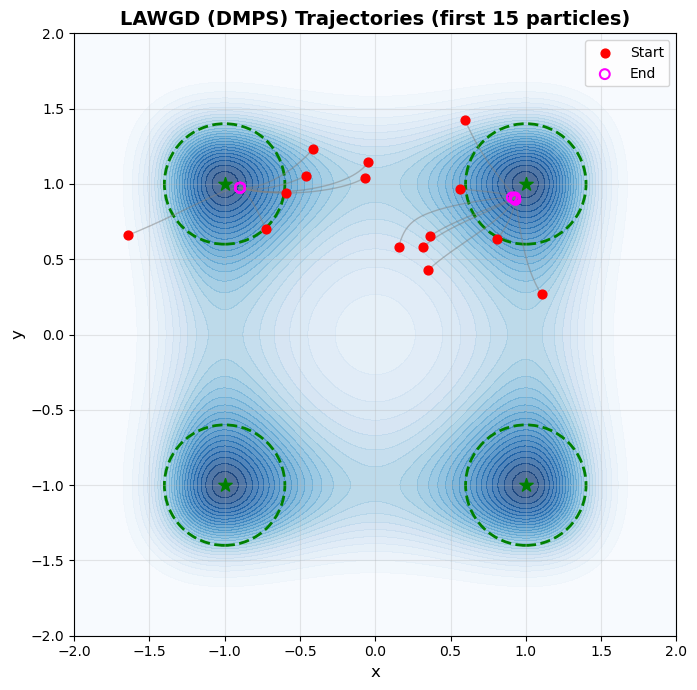

In [13]:
# ============================================================
# Visualization 2: Trajectories (DMPS)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax.plot(X_lawgd_traj[i, 0, :], X_lawgd_traj[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax.scatter(X_lawgd_traj[:n_show_traj, 0, 0], X_lawgd_traj[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax.scatter(X_lawgd_traj[:n_show_traj, 0, -1], X_lawgd_traj[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=15, label='End')

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'LAWGD (DMPS) Trajectories (first {n_show_traj} particles)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

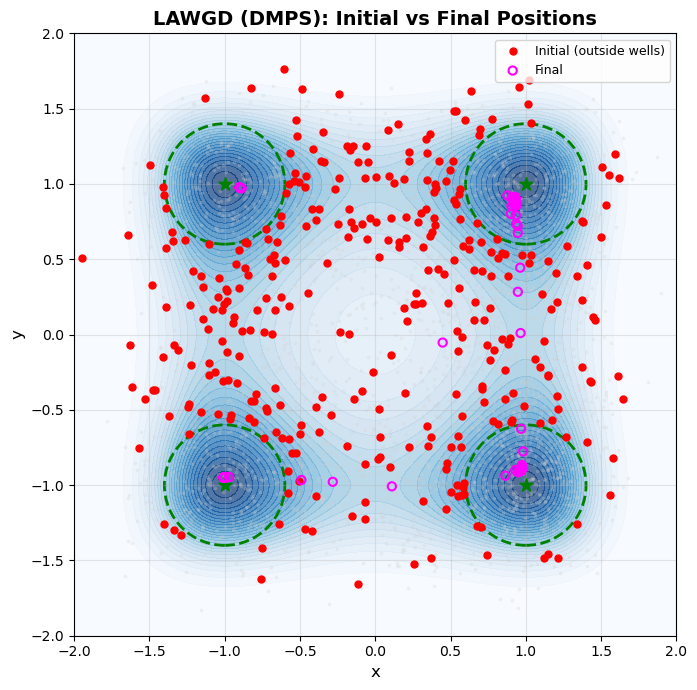

In [14]:
# ============================================================
# Visualization 1: Initial vs Final Positions (DMPS)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2)
ax.scatter(X_lawgd_traj[:, 0, 0], X_lawgd_traj[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax.scatter(X_lawgd_traj[:, 0, -1], X_lawgd_traj[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=15)

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('LAWGD (DMPS): Initial vs Final Positions', fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# ============================================================
# DMPS Step = 3000
# ============================================================

# Step 5: DMPS iteration with DM kernel
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 3000
h_lawgd = 1  # Step size

X_lawgd_traj = np.zeros((n_particles, 2, n_iter_lawgd))
X_lawgd_traj[:, :, 0] = X_lawgd_init.copy()

print(f"\n{'='*60}")
print("Step 3: Running DMPS iterations (DM kernel-based)...")
print(f"{'='*60}")
print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Step size: {h_lawgd}")
print(f"Active modes: {k_modes}")

for t in range(n_iter_lawgd - 1):
    X_curr = X_lawgd_traj[:, :, t]
    
    # Evaluate kernel between current particles and training data
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto eigenmodes: c = Φ^T @ K(x, X_tar)
    # eigvecs_K has shape (n_data, n_data), we use selected modes
    eigvecs_selected = eigvecs_K[:, mode_start:mode_end]  # (n_data, k_modes)
    c = eigvecs_selected.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ @ c_inv
    f_inv = eigvecs_selected @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    if (t+1) % 100 == 0 or t == 0:
        print(f"\r  [DM] Iteration {t+1}/{n_iter_lawgd-1}  ", end='', flush=True)

print()  # Print newline after loop
print("DMPS iteration complete!")

# Step 6: Compute final metrics
dist_final_to_wells = np.array([np.linalg.norm(X_lawgd_traj[:, :, -1] - center, axis=1) for center in well_centers])
min_dist_final = np.min(dist_final_to_wells, axis=0)
in_well_final = min_dist_final <= well_radius

print(f"\n{'='*60}")
print("DMPS Results:")
print(f"{'='*60}")
print(f"Initial particles (outside wells): {n_particles}")
print(f"Final particles inside wells: {np.sum(in_well_final)} ({100*np.sum(in_well_final)/n_particles:.1f}%)")
print(f"Final particles still outside: {n_particles - np.sum(in_well_final)} ({100*(n_particles - np.sum(in_well_final))/n_particles:.1f}%)")
print(f"{'='*60}")


Step 3: Running DMPS iterations (DM kernel-based)...
Particles: 345
Iterations: 3000
Step size: 1
Active modes: 62
  [DM] Iteration 2900/2999  
DMPS iteration complete!

DMPS Results:
Initial particles (outside wells): 345
Final particles inside wells: 345 (100.0%)
Final particles still outside: 0 (0.0%)

DMPS iteration complete!

DMPS Results:
Initial particles (outside wells): 345
Final particles inside wells: 345 (100.0%)
Final particles still outside: 0 (0.0%)


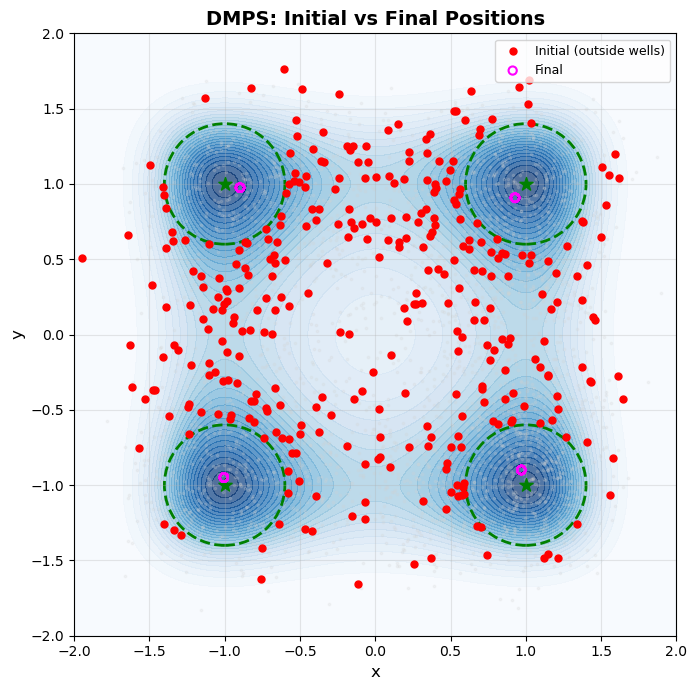

In [16]:
# ============================================================
# Visualization 1: Initial vs Final Positions (DMPS)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2)
ax.scatter(X_lawgd_traj[:, 0, 0], X_lawgd_traj[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax.scatter(X_lawgd_traj[:, 0, -1], X_lawgd_traj[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=15)

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('DMPS: Initial vs Final Positions', fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

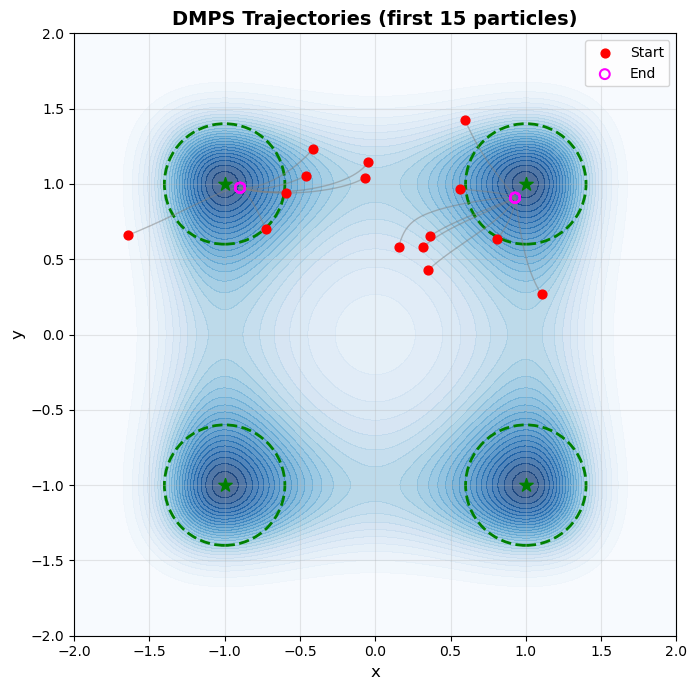

In [17]:
# ============================================================
# Visualization 2: Trajectories (DMPS)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax.plot(X_lawgd_traj[i, 0, :], X_lawgd_traj[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax.scatter(X_lawgd_traj[:n_show_traj, 0, 0], X_lawgd_traj[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax.scatter(X_lawgd_traj[:n_show_traj, 0, -1], X_lawgd_traj[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=15, label='End')

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'DMPS Trajectories (first {n_show_traj} particles)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

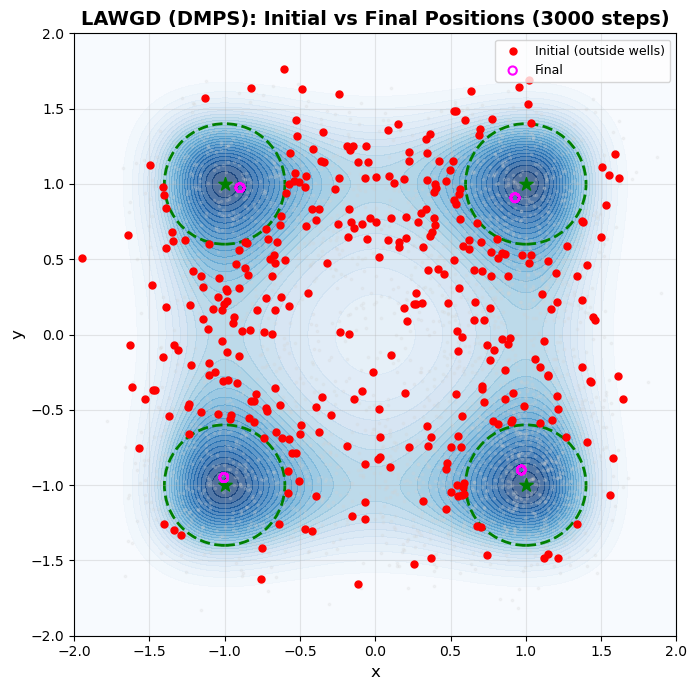

In [19]:
# ============================================================
# Visualization 1: Initial vs Final Positions (DMPS, 3000 steps)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2)
ax.scatter(X_lawgd_traj[:, 0, 0], X_lawgd_traj[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax.scatter(X_lawgd_traj[:, 0, -1], X_lawgd_traj[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=15)

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('LAWGD (DMPS): Initial vs Final Positions (3000 steps)', fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

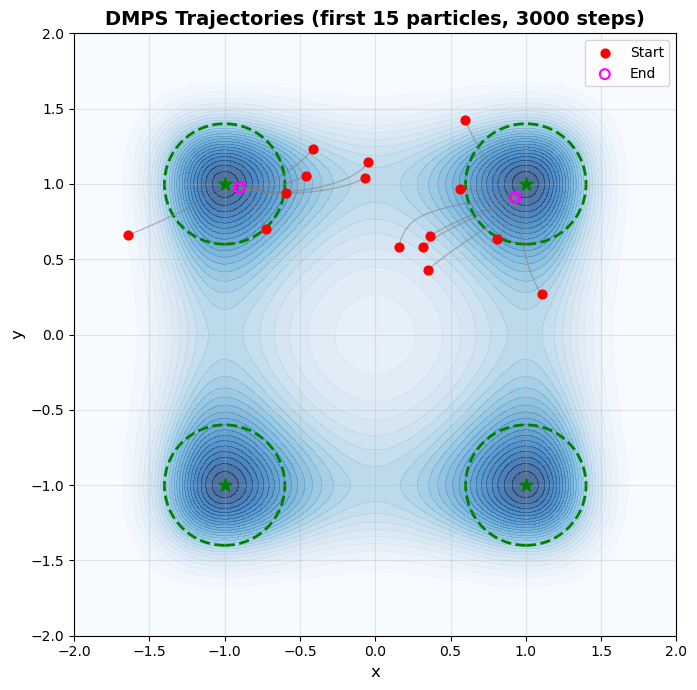

In [18]:
# ============================================================
# Visualization 2: Trajectories (DMPS, 3000 steps)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax.plot(X_lawgd_traj[i, 0, :], X_lawgd_traj[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax.scatter(X_lawgd_traj[:n_show_traj, 0, 0], X_lawgd_traj[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax.scatter(X_lawgd_traj[:n_show_traj, 0, -1], X_lawgd_traj[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=15, label='End')

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'DMPS Trajectories (first {n_show_traj} particles, 3000 steps)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Convergence Analysis: DMPS with Metrics Tracking

Run DMPS for 3000 steps and track convergence metrics every 100 steps

In [20]:
# ============================================================
# DMPS with Metrics Tracking (0-3000 steps, every 100 steps)
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print("DMPS: Running 3000 iterations with metrics tracking...")
print("="*60)

# Step 1: Setup parameters
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 3000
h_lawgd = 1  # Step size
record_interval = 100  # Record metrics every 100 steps
n_records = n_iter_lawgd // record_interval + 1  # Include step 0

# Initialize trajectory storage
X_lawgd_traj_dm = np.zeros((n_particles, 2, n_iter_lawgd + 1))
X_lawgd_traj_dm[:, :, 0] = X_lawgd_init.copy()

# Initialize metrics storage
metrics_dm = {
    'steps': [],
    'well_coverage': [],  # Percentage of particles in wells
    'avg_potential': [],  # Average potential energy
    'movement_rate': []   # Average displacement per step
}

print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Recording interval: {record_interval} steps")
print(f"Total records: {n_records}")

# Helper function to compute metrics
def compute_metrics(X_current, X_previous=None):
    """Compute convergence metrics for current particle positions"""
    # 1. Well coverage: percentage in wells
    dist_to_wells = np.array([np.linalg.norm(X_current - center, axis=1) 
                              for center in well_centers])
    min_dist = np.min(dist_to_wells, axis=0)
    in_well = min_dist <= well_radius
    coverage = 100.0 * np.sum(in_well) / len(X_current)
    
    # 2. Average potential energy
    avg_V = np.mean(potential.V(X_current))
    
    # 3. Movement rate (only if previous positions available)
    if X_previous is not None:
        displacement = np.linalg.norm(X_current - X_previous, axis=1)
        movement = np.mean(displacement)
    else:
        movement = 0.0
    
    return coverage, avg_V, movement

# Record initial state (step 0)
coverage_0, avg_V_0, _ = compute_metrics(X_lawgd_traj_dm[:, :, 0])
metrics_dm['steps'].append(0)
metrics_dm['well_coverage'].append(coverage_0)
metrics_dm['avg_potential'].append(avg_V_0)
metrics_dm['movement_rate'].append(0.0)

print(f"\nInitial state (step 0):")
print(f"  Well coverage: {coverage_0:.2f}%")
print(f"  Avg potential: {avg_V_0:.4f}")

# Step 2: Run LAWGD iterations with DM kernel
print(f"\n{'='*60}")
print("Running DMPS iterations...")
print(f"{'='*60}")

for t in range(n_iter_lawgd):
    X_curr = X_lawgd_traj_dm[:, :, t]
    
    # Evaluate kernel between current particles and training data
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto eigenmodes: c = Φ^T @ K(x, X_tar)
    eigvecs_selected = eigvecs_K[:, mode_start:mode_end]  # (n_data, k_modes)
    c = eigvecs_selected.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ @ c_inv
    f_inv = eigvecs_selected @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj_dm[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    # Record metrics every record_interval steps
    if (t + 1) % record_interval == 0:
        X_prev = X_lawgd_traj_dm[:, :, t]
        X_next = X_lawgd_traj_dm[:, :, t+1]
        coverage, avg_V, movement = compute_metrics(X_next, X_prev)
        
        metrics_dm['steps'].append(t + 1)
        metrics_dm['well_coverage'].append(coverage)
        metrics_dm['avg_potential'].append(avg_V)
        metrics_dm['movement_rate'].append(movement)
    
    # Progress indicator
    if (t+1) % 200 == 0 or t == 0:
        print(f"\r  [DM] Iteration {t+1}/{n_iter_lawgd}  ", end='', flush=True)

print()  # Newline after loop
print("DMPS iteration complete!")

# Step 3: Final summary
final_coverage = metrics_dm['well_coverage'][-1]
final_potential = metrics_dm['avg_potential'][-1]
final_movement = metrics_dm['movement_rate'][-1]

print(f"\n{'='*60}")
print("DMPS Final Results:")
print(f"{'='*60}")
print(f"Final well coverage: {final_coverage:.2f}%")
print(f"Final avg potential: {final_potential:.4f}")
print(f"Final movement rate: {final_movement:.6f}")
print(f"Total records: {len(metrics_dm['steps'])}")
print(f"{'='*60}")

# Convert metrics to numpy arrays for easier plotting
for key in ['steps', 'well_coverage', 'avg_potential', 'movement_rate']:
    metrics_dm[key] = np.array(metrics_dm[key])

print("\n✓ DMPS metrics saved in 'metrics_dm' dictionary")

DMPS: Running 3000 iterations with metrics tracking...
Particles: 345
Iterations: 3000
Recording interval: 100 steps
Total records: 31

Initial state (step 0):
  Well coverage: 0.00%
  Avg potential: 1.1858

Running DMPS iterations...
  [DM] Iteration 3000/3000  
DMPS iteration complete!

DMPS Final Results:
Final well coverage: 100.00%
Final avg potential: 0.0367
Final movement rate: 0.000000
Total records: 31

✓ DMPS metrics saved in 'metrics_dm' dictionary
  [DM] Iteration 3000/3000  
DMPS iteration complete!

DMPS Final Results:
Final well coverage: 100.00%
Final avg potential: 0.0367
Final movement rate: 0.000000
Total records: 31

✓ DMPS metrics saved in 'metrics_dm' dictionary


2.8.0+cu128 True
12.8
NVIDIA GeForce RTX 5050 Laptop GPU
Shape of X: (2499, 2)
Shape of Y: (2499, 2)
(1749, 2)
Epoch: 1 	Training Loss: 0.588980 	Validation Loss: 0.374600
Saving model, validation loss improved: 0.374600 < 10000.000000
Epoch: 2 	Training Loss: 0.311859 	Validation Loss: 0.208398
Saving model, validation loss improved: 0.208398 < 0.374600
Epoch: 3 	Training Loss: 0.197125 	Validation Loss: 0.159784
Saving model, validation loss improved: 0.159784 < 0.208398
Epoch: 1 	Training Loss: 0.588980 	Validation Loss: 0.374600
Saving model, validation loss improved: 0.374600 < 10000.000000
Epoch: 2 	Training Loss: 0.311859 	Validation Loss: 0.208398
Saving model, validation loss improved: 0.208398 < 0.374600
Epoch: 3 	Training Loss: 0.197125 	Validation Loss: 0.159784
Saving model, validation loss improved: 0.159784 < 0.208398
Epoch: 4 	Training Loss: 0.165847 	Validation Loss: 0.152310
Saving model, validation loss improved: 0.152310 < 0.159784
Epoch: 5 	Training Loss: 0.160033 

Processing batches:   0%|          | 0/28 [00:00<?, ?batch/s]c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:546: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  batch_J = vmap(jac_fn)(batch_inputs)  # (batch_size, F, D)
c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:547: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migra

saving FNN a and b to:  a_b_example_quadruple_well.jbl
Outer Epoch 1/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 174.35batch/s]
c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:359: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:398: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:359: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\xyc93\Documents\dmps_koopman\solver_sdmd_torch_gpu.py:398: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch: 1 	Training Loss: 0.043485 val loss: 0.042312
Saving model, val loss improved from 1000000000000000.000000 to 0.042312
Epoch: 2 	Training Loss: 0.043434 val loss: 0.042263
Saving model, val loss improved from 0.042312 to 0.042263
EarlyStopping counter: 1 out of 7
Epoch 1 time: 0.31 seconds
Outer Epoch 2/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 142.41batch/s]



Epoch: 1 	Training Loss: 0.043415 val loss: 0.042244
Saving model, val loss improved from 0.042263 to 0.042244
Epoch: 2 	Training Loss: 0.043365 val loss: 0.042194
Saving model, val loss improved from 0.042244 to 0.042194
EarlyStopping counter: 1 out of 7
Epoch 2 time: 0.31 seconds
Outer Epoch 3/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 154.08batch/s]



Epoch: 1 	Training Loss: 0.043346 val loss: 0.042176
Saving model, val loss improved from 0.042194 to 0.042176
Epoch: 2 	Training Loss: 0.043296 val loss: 0.042127
Saving model, val loss improved from 0.042176 to 0.042127
EarlyStopping counter: 1 out of 7
Epoch 3 time: 0.30 seconds
Outer Epoch 4/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 154.26batch/s]



Epoch: 1 	Training Loss: 0.043277 val loss: 0.042109
Saving model, val loss improved from 0.042127 to 0.042109
Epoch: 2 	Training Loss: 0.043228 val loss: 0.042060
Saving model, val loss improved from 0.042109 to 0.042060
EarlyStopping counter: 1 out of 7
Epoch 4 time: 0.29 seconds
Outer Epoch 5/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 180.91batch/s]



Epoch: 1 	Training Loss: 0.043209 val loss: 0.042043
Saving model, val loss improved from 0.042060 to 0.042043
Epoch: 2 	Training Loss: 0.043160 val loss: 0.041995
Saving model, val loss improved from 0.042043 to 0.041995
EarlyStopping counter: 1 out of 7
Epoch 5 time: 0.26 seconds
Outer Epoch 6/6


Processing batches: 100%|██████████| 28/28 [00:00<00:00, 164.76batch/s]



Epoch: 1 	Training Loss: 0.043143 val loss: 0.041977
Saving model, val loss improved from 0.041995 to 0.041977
Epoch: 2 	Training Loss: 0.043094 val loss: 0.041929
Saving model, val loss improved from 0.041977 to 0.041929
EarlyStopping counter: 1 out of 7
Epoch 6 time: 0.29 seconds
SDMD eigenvalues shape (20,)
SDMD eigenvalues [ 9.99995394e-01+0.00000000e+00j  9.17266067e-01+0.00000000e+00j
  9.00666433e-01+0.00000000e+00j  4.88703207e-01+0.00000000e+00j
  4.35932641e-01+0.00000000e+00j  2.42885834e-01+0.00000000e+00j
  2.18678432e-01+0.00000000e+00j  6.54137030e-02+0.00000000e+00j
  5.12463499e-02+0.00000000e+00j  9.08629564e-03+0.00000000e+00j
  1.83773826e-03+0.00000000e+00j  5.56933067e-04+0.00000000e+00j
  4.44228037e-05-9.74802439e-06j  4.44228037e-05+9.74802439e-06j
  7.52745843e-07+0.00000000e+00j  7.42530658e-08+0.00000000e+00j
 -1.45526546e-07+0.00000000e+00j -1.02644837e-06+0.00000000e+00j
 -1.87933618e-05+0.00000000e+00j -1.03755786e-04+0.00000000e+00j]
SDMD eigenvectors sh

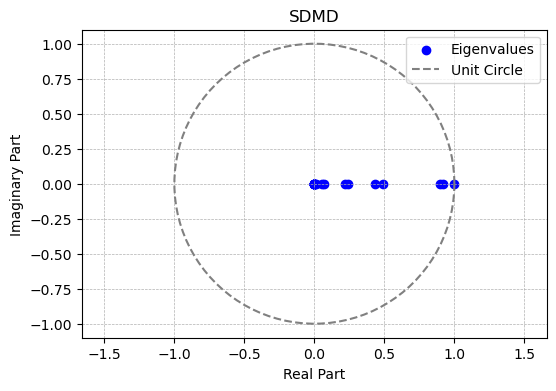

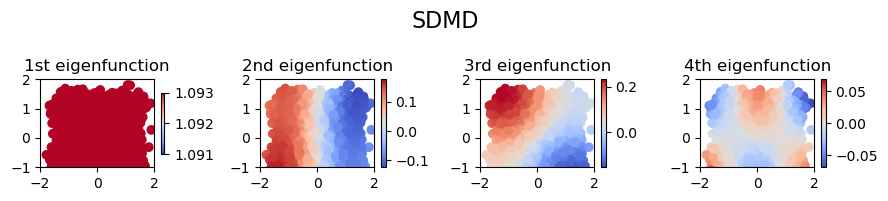


Constructing Generator Inverse for LAWGD...
  - eigvals_K_sdmd shape: (20,)
  - eigvecs_K_sdmd shape: (2499, 20)


In [21]:
# ============================================================
# SDMD: Stochastic Dynamic Mode Decomposition with Dictionary Learning
# ============================================================

import torch
torch.cuda.empty_cache()
# import torch.nn.functional as F
# from numpy import linalg as la
# from numpy import *
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch


print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

# Reshape data_X and data_Y into a single column
X = X_tar  # 2D features
Y = X_tar_next  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)



#### SDMD Test ####
checkpoint_file= 'quadruple_well_2d_example_ckpt001.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[20], n_psi_train=17).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_quadruple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= dt)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues_sdmd = solver.eigenvalues.T
efuns_sdmd = solver.eigenfunctions(X)
evectors_sdmd = solver.eigenvectors.T
# kpm_modes = solver.compute_mode().T
N_dict_sdmd = np.shape(evalues_sdmd)[0]
Psi_X_sdmd = solver.get_Psi_X()
Psi_Y_sdmd = solver.get_Psi_Y()
Koopman_matrix_K_sdmd = solver.K

outputs_sdmd = {
    'efuns': efuns_sdmd,
    'evalues': evalues_sdmd,
    'evectors': evectors_sdmd,
    # 'kpm_modes': kpm_modes,
    'N_dict': N_dict_sdmd,
    'K': Koopman_matrix_K_sdmd,
    # 'Psi_X': Psi_X_sdmd,
    # 'Psi_Y': Psi_Y_sdmd,
    }


# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

# Assuming 'efuns_sdmd' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues_sdmd is a numpy array of complex numbers
print("SDMD eigenvalues shape", evalues_sdmd.shape)
print("SDMD eigenvalues", evalues_sdmd)
print("SDMD eigenvectors shape", evectors_sdmd.shape)
print("SDMD eigenvectors", evectors_sdmd)

# Plot eigenvalues on unit circle
real_parts = evalues_sdmd.real
imag_parts = evalues_sdmd.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('SDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(9, 2))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns_sdmd)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns_sdmd)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns_sdmd)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns_sdmd)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns_sdmd)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

fig.suptitle('SDMD', fontsize=16)
plt.tight_layout()
plt.show()

# ============================================================
# Construct Generator Eigenvalues and Inverse Weights (for LAWGD)
# ============================================================
print("\n" + "="*60)
print("Constructing Generator Inverse for LAWGD...")
print("="*60)

# Extract real part of eigenvalues (SDMD eigenvalues are already computed)
lambda_ns_sdmd = evalues_sdmd.real

# Construct generator eigenvalues: λ_gen = (λ_K - 1) / dt
lambda_gen_sdmd = (lambda_ns_sdmd - 1.0) / dt

# Build inverse generator weights (for LAWGD)
tol_sdmd = 1e-6
lambda_ns_inv_sdmd = np.zeros_like(lambda_ns_sdmd)
mask_sdmd = lambda_ns_sdmd >= tol_sdmd
lambda_ns_inv_sdmd[mask_sdmd] = dt / (lambda_ns_sdmd[mask_sdmd] + 0.001)

# Store results for LAWGD (following DM method naming convention)
eigvals_K_sdmd = lambda_ns_sdmd.copy()
eigvecs_K_sdmd = efuns_sdmd.copy()  # ✓ Use eigenfunctions (values on data points)!
lambda_gen_full_sdmd = lambda_gen_sdmd.copy()

print(f"  - eigvals_K_sdmd shape: {eigvals_K_sdmd.shape}")
print(f"  - eigvecs_K_sdmd shape: {eigvecs_K_sdmd.shape}")
print("="*60)

In [22]:
# ============================================================
# Koopman(SDMD): Langevin-Adjusted Weighted Gradient Descent with SDMD
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print("Koopman(SDMD): Using SDMD Koopman Spectrum")
print("="*60)
print("Strategy: Use SDMD eigenvalues/eigenvectors + DM kernel/normalization")
print("="*60)

# Step 1: Reuse initial particles from DMPS (or generate new ones)
# We'll use the same initialization as DM method
if 'X_lawgd_init' not in globals():
    print("\nGenerating initial particles outside wells...")
    n_init_particles = 500
    
    # Generate initialization trajectory
    X_init_traj = generate_langevin_trajectory(potential, n_samples=n_init_particles, 
                                               dt=0.1, n_substeps=10, burnin=500)
    
    well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
    well_radius = 0.4
    
    dist_to_wells = np.array([np.linalg.norm(X_init_traj - center, axis=1) for center in well_centers])
    min_dist_to_wells = np.min(dist_to_wells, axis=0)
    mask_outside = min_dist_to_wells > well_radius
    X_lawgd_init = X_init_traj[mask_outside]
    
    print(f"Particles outside wells: {X_lawgd_init.shape[0]}")
else:
    print(f"\nReusing existing initial particles: {X_lawgd_init.shape[0]}")

# Step 2: Prepare Koopman(SDMD) using SDMD-based Koopman spectrum
print(f"\n{'='*60}")
print("Step 2: Preparing Koopman(SDMD) with SDMD Koopman spectrum...")
print(f"{'='*60}")

# Use SDMD method results (computed in previous cell)
eigvals_K = eigvals_K_sdmd.copy()
eigvecs_K = eigvecs_K_sdmd.copy()
lambda_gen = lambda_gen_full_sdmd.copy()

print(f"SDMD eigenvalues shape: {eigvals_K.shape}")
print(f"SDMD eigenvectors shape: {eigvecs_K.shape}")

# Mode selection strategy: use all valid modes
n_skip = 1  # Skip first 1 eigenvalues (constant modes)
eig_threshold = 0.01  # Threshold for valid eigenvalues (exclude near-zero eigenvalues)

# Find valid eigenvalues: skip first n_skip, and keep those > threshold
eigvals_after_skip = eigvals_K[n_skip:]
valid_mask = eigvals_after_skip.real > eig_threshold
n_valid = np.sum(valid_mask)

# Use ALL valid modes
k_modes = n_valid
mode_start = n_skip
mode_end = mode_start + k_modes

print(f"\n  Mode selection strategy: use all valid modes")
print(f"    - Total eigenvalues: {len(eigvals_K)}")
print(f"    - Skipping first {n_skip} eigenvalues (constant modes)")
print(f"    - Eigenvalue threshold: λ > {eig_threshold} (exclude near-zero)")
print(f"    - Skipped due to threshold: {len(eigvals_K) - n_skip - k_modes}")
print(f"    - **Using {k_modes} valid modes** (modes {mode_start+1} to {mode_end})")
print(f"\n  Selected eigenvalues for Koopman(SDMD):")
for i in range(mode_start, min(mode_end, mode_start + 10)):  # Show first 10
    print(f"    Mode {i+1}: λ = {eigvals_K[i].real:.6f}, λ_gen = {lambda_gen[i].real:.2f}")
if mode_end > mode_start + 10:
    print(f"    ... ({mode_end - mode_start - 10} more modes)")

# Build inverse generator weights for selected modes
lambda_gen_selected = lambda_gen[mode_start:mode_end]
tol_gen = 1e-6
lambda_gen_inv_selected = np.zeros(k_modes, dtype=complex)
mask_nonzero = np.abs(lambda_gen_selected) > tol_gen
lambda_gen_inv_selected[mask_nonzero] = 1.0 / lambda_gen_selected[mask_nonzero]

print(f"\n  Generator eigenvalue range: [{lambda_gen_selected.real.min():.2f}, {lambda_gen_selected.real.max():.2f}]")

# Step 3: Koopman(SDMD) iteration with SDMD spectrum
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 1000
h_lawgd = 1  # Step size

X_lawgd_traj_sdmd = np.zeros((n_particles, 2, n_iter_lawgd))
X_lawgd_traj_sdmd[:, :, 0] = X_lawgd_init.copy()

print(f"\n{'='*60}")
print("Step 3: Running Koopman(SDMD) iterations (SDMD spectrum)...")
print(f"{'='*60}")
print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Step size: {h_lawgd}")
print(f"Active modes: {k_modes}")

for t in range(n_iter_lawgd - 1):
    X_curr = X_lawgd_traj_sdmd[:, :, t]
    
    # Evaluate kernel between current particles and training data (DM kernel)
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto SDMD eigenmodes: c = Φ_SDMD^T @ K(x, X_tar)
    eigvecs_selected = eigvecs_K[:, mode_start:mode_end]  # (n_data, k_modes)
    c = eigvecs_selected.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ_SDMD @ c_inv
    f_inv = eigvecs_selected @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using DM kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj_sdmd[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    if (t+1) % 100 == 0 or t == 0:
        print(f"\r  [SDMD] Iteration {t+1}/{n_iter_lawgd-1}  ", end='', flush=True)

print()  # Print newline after loop
print("Koopman(SDMD) iteration complete!")

# Step 4: Compute final metrics
dist_final_to_wells = np.array([np.linalg.norm(X_lawgd_traj_sdmd[:, :, -1] - center, axis=1) for center in well_centers])
min_dist_final = np.min(dist_final_to_wells, axis=0)
in_well_final = min_dist_final <= well_radius

print(f"\n{'='*60}")
print("Koopman(SDMD) Results:")
print(f"{'='*60}")
print(f"Initial particles (outside wells): {n_particles}")
print(f"Final particles inside wells: {np.sum(in_well_final)} ({100*np.sum(in_well_final)/n_particles:.1f}%)")
print(f"Final particles still outside: {n_particles - np.sum(in_well_final)} ({100*(n_particles - np.sum(in_well_final))/n_particles:.1f}%)")
print(f"{'='*60}")

Koopman(SDMD): Using SDMD Koopman Spectrum
Strategy: Use SDMD eigenvalues/eigenvectors + DM kernel/normalization

Reusing existing initial particles: 345

Step 2: Preparing Koopman(SDMD) with SDMD Koopman spectrum...
SDMD eigenvalues shape: (20,)
SDMD eigenvectors shape: (2499, 20)

  Mode selection strategy: use all valid modes
    - Total eigenvalues: 20
    - Skipping first 1 eigenvalues (constant modes)
    - Eigenvalue threshold: λ > 0.01 (exclude near-zero)
    - Skipped due to threshold: 11
    - **Using 8 valid modes** (modes 2 to 9)

  Selected eigenvalues for Koopman(SDMD):
    Mode 2: λ = 0.917266, λ_gen = -0.83
    Mode 3: λ = 0.900666, λ_gen = -0.99
    Mode 4: λ = 0.488703, λ_gen = -5.11
    Mode 5: λ = 0.435933, λ_gen = -5.64
    Mode 6: λ = 0.242886, λ_gen = -7.57
    Mode 7: λ = 0.218678, λ_gen = -7.81
    Mode 8: λ = 0.065414, λ_gen = -9.35
    Mode 9: λ = 0.051246, λ_gen = -9.49

  Generator eigenvalue range: [-9.49, -0.83]

Step 3: Running Koopman(SDMD) iterations (

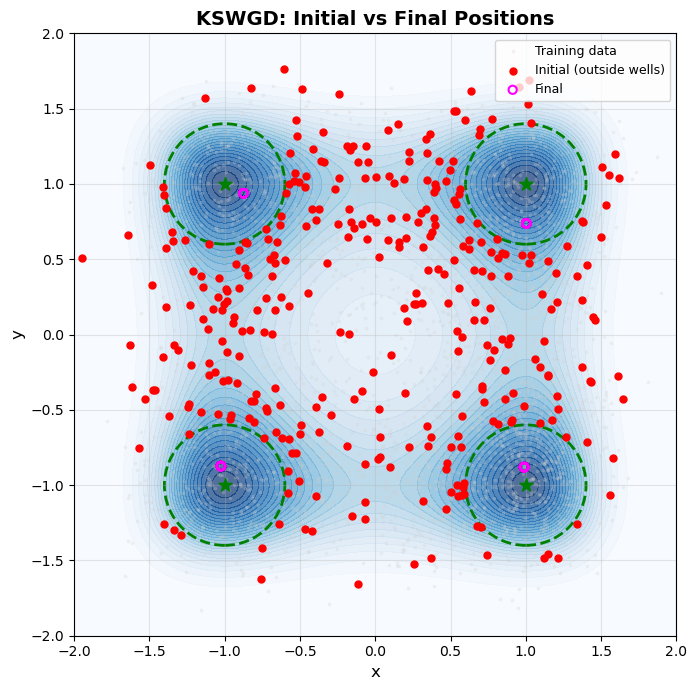

In [31]:
# ============================================================
# Visualization 1: Initial vs Final Positions (Koopman(SDMD))
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='Training data')
ax.scatter(X_lawgd_traj_sdmd[:, 0, 0], X_lawgd_traj_sdmd[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax.scatter(X_lawgd_traj_sdmd[:, 0, -1], X_lawgd_traj_sdmd[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=15)

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('KSWGD: Initial vs Final Positions', fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

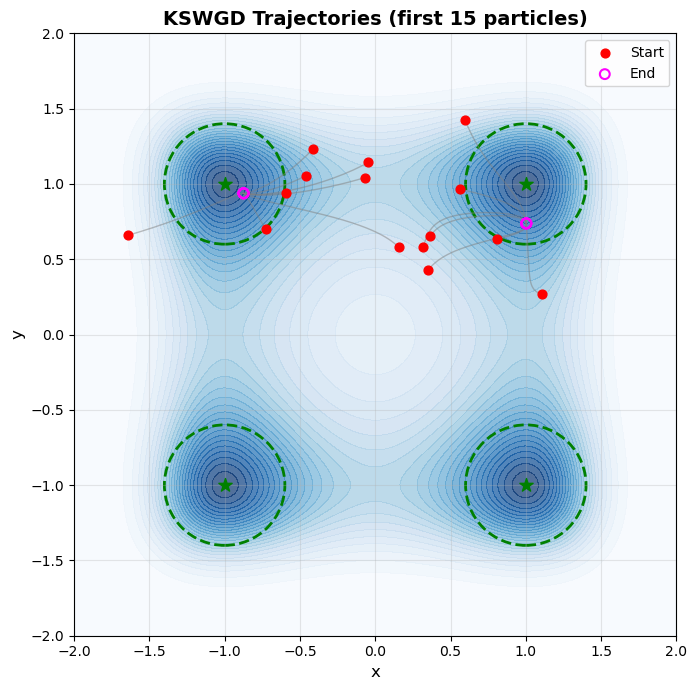

In [32]:
# ============================================================
# Visualization 2: Trajectories (Koopman(SDMD))
# ============================================================

fig, ax = plt.subplots(figsize=(8, 7))

ax.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax.plot(X_lawgd_traj_sdmd[i, 0, :], X_lawgd_traj_sdmd[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax.scatter(X_lawgd_traj_sdmd[:n_show_traj, 0, 0], X_lawgd_traj_sdmd[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax.scatter(X_lawgd_traj_sdmd[:n_show_traj, 0, -1], X_lawgd_traj_sdmd[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=15, label='End')

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax.add_patch(circle)

ax.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'KSWGD Trajectories (first {n_show_traj} particles)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Convergence Analysis: Koopman(SDMD) with Metrics Tracking

Run Koopman(SDMD) for 3000 steps and track convergence metrics every 100 steps

In [25]:
# ============================================================
# Koopman(SDMD) with Metrics Tracking (0-3000 steps, every 100 steps)
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print("Koopman(SDMD): Running 3000 iterations with metrics tracking...")
print("="*60)

# Step 1: Prepare SDMD Koopman spectrum (reuse from previous cell)
eigvals_K_sdmd_analysis = eigvals_K_sdmd.copy()
eigvecs_K_sdmd_analysis = eigvecs_K_sdmd.copy()
lambda_gen_sdmd_analysis = lambda_gen_full_sdmd.copy()

# Mode selection (same as before)
n_skip = 1
eig_threshold = 0.01
eigvals_after_skip = eigvals_K_sdmd_analysis[n_skip:]
valid_mask = eigvals_after_skip.real > eig_threshold
n_valid = np.sum(valid_mask)

k_modes_sdmd = n_valid
mode_start_sdmd = n_skip
mode_end_sdmd = mode_start_sdmd + k_modes_sdmd

print(f"SDMD modes: {k_modes_sdmd} (from {mode_start_sdmd+1} to {mode_end_sdmd})")

# Build inverse generator weights
lambda_gen_selected_sdmd = lambda_gen_sdmd_analysis[mode_start_sdmd:mode_end_sdmd]
tol_gen_sdmd = 1e-6
lambda_gen_inv_selected_sdmd = np.zeros(k_modes_sdmd, dtype=complex)
mask_nonzero_sdmd = np.abs(lambda_gen_selected_sdmd) > tol_gen_sdmd
lambda_gen_inv_selected_sdmd[mask_nonzero_sdmd] = 1.0 / lambda_gen_selected_sdmd[mask_nonzero_sdmd]

# Step 2: Setup parameters
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 3000
h_lawgd = 1  # Step size
record_interval = 100  # Record metrics every 100 steps
n_records = n_iter_lawgd // record_interval + 1  # Include step 0

# Initialize trajectory storage
X_lawgd_traj_sdmd = np.zeros((n_particles, 2, n_iter_lawgd + 1))
X_lawgd_traj_sdmd[:, :, 0] = X_lawgd_init.copy()

# Initialize metrics storage
metrics_sdmd = {
    'steps': [],
    'well_coverage': [],  # Percentage of particles in wells
    'avg_potential': [],  # Average potential energy
    'movement_rate': []   # Average displacement per step
}

print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Recording interval: {record_interval} steps")
print(f"Total records: {n_records}")

# Record initial state (step 0)
coverage_0, avg_V_0, _ = compute_metrics(X_lawgd_traj_sdmd[:, :, 0])
metrics_sdmd['steps'].append(0)
metrics_sdmd['well_coverage'].append(coverage_0)
metrics_sdmd['avg_potential'].append(avg_V_0)
metrics_sdmd['movement_rate'].append(0.0)

print(f"\nInitial state (step 0):")
print(f"  Well coverage: {coverage_0:.2f}%")
print(f"  Avg potential: {avg_V_0:.4f}")

# Step 3: Run Koopman(SDMD) iterations with SDMD spectrum
print(f"\n{'='*60}")
print("Running Koopman(SDMD) iterations...")
print(f"{'='*60}")

for t in range(n_iter_lawgd):
    X_curr = X_lawgd_traj_sdmd[:, :, t]
    
    # Evaluate kernel between current particles and training data (DM kernel)
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto SDMD eigenmodes: c = Φ_SDMD^T @ K(x, X_tar)
    eigvecs_selected_sdmd = eigvecs_K_sdmd_analysis[:, mode_start_sdmd:mode_end_sdmd]  # (n_data, k_modes)
    c = eigvecs_selected_sdmd.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected_sdmd[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ_SDMD @ c_inv
    f_inv = eigvecs_selected_sdmd @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using DM kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj_sdmd[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    # Record metrics every record_interval steps
    if (t + 1) % record_interval == 0:
        X_prev = X_lawgd_traj_sdmd[:, :, t]
        X_next = X_lawgd_traj_sdmd[:, :, t+1]
        coverage, avg_V, movement = compute_metrics(X_next, X_prev)
        
        metrics_sdmd['steps'].append(t + 1)
        metrics_sdmd['well_coverage'].append(coverage)
        metrics_sdmd['avg_potential'].append(avg_V)
        metrics_sdmd['movement_rate'].append(movement)
    
    # Progress indicator
    if (t+1) % 200 == 0 or t == 0:
        print(f"\r  [SDMD] Iteration {t+1}/{n_iter_lawgd}  ", end='', flush=True)

print()  # Newline after loop
print("Koopman(SDMD) iteration complete!")

# Step 4: Final summary
final_coverage = metrics_sdmd['well_coverage'][-1]
final_potential = metrics_sdmd['avg_potential'][-1]
final_movement = metrics_sdmd['movement_rate'][-1]

print(f"\n{'='*60}")
print("Koopman(SDMD) Final Results:")
print(f"{'='*60}")
print(f"Final well coverage: {final_coverage:.2f}%")
print(f"Final avg potential: {final_potential:.4f}")
print(f"Final movement rate: {final_movement:.6f}")
print(f"Total records: {len(metrics_sdmd['steps'])}")
print(f"{'='*60}")

# Convert metrics to numpy arrays for easier plotting
for key in ['steps', 'well_coverage', 'avg_potential', 'movement_rate']:
    metrics_sdmd[key] = np.array(metrics_sdmd[key])

print("\n✓ Koopman(SDMD) metrics saved in 'metrics_sdmd' dictionary")

Koopman(SDMD): Running 3000 iterations with metrics tracking...
SDMD modes: 8 (from 2 to 9)
Particles: 345
Iterations: 3000
Recording interval: 100 steps
Total records: 31

Initial state (step 0):
  Well coverage: 0.00%
  Avg potential: 1.1858

Running Koopman(SDMD) iterations...
  [SDMD] Iteration 3000/3000  
Koopman(SDMD) iteration complete!

Koopman(SDMD) Final Results:
Final well coverage: 100.00%
Final avg potential: 0.0946
Final movement rate: 0.000000
Total records: 31

✓ Koopman(SDMD) metrics saved in 'metrics_sdmd' dictionary
  [SDMD] Iteration 3000/3000  
Koopman(SDMD) iteration complete!

Koopman(SDMD) Final Results:
Final well coverage: 100.00%
Final avg potential: 0.0946
Final movement rate: 0.000000
Total records: 31

✓ Koopman(SDMD) metrics saved in 'metrics_sdmd' dictionary


## Convergence Comparison: DMPS vs Koopman(SDMD)

Visualize convergence metrics over 3000 iterations to compare the two methods

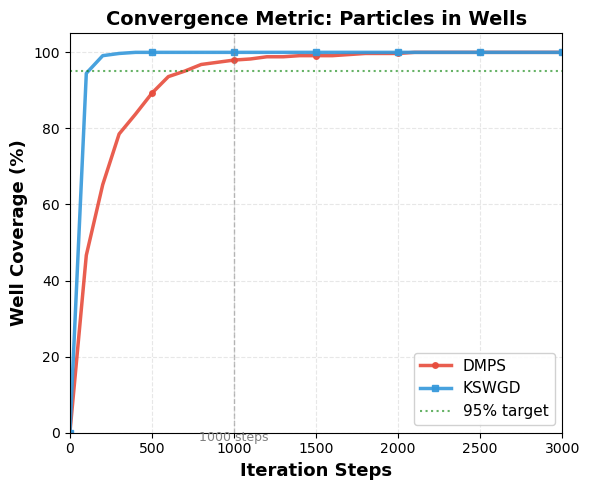

In [29]:
# ============================================================
# Convergence Comparison Visualization: Plot 1 - Well Coverage
# ============================================================

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

# Color scheme
color_dm = '#E74C3C'      # Red for DMPS
color_sdmd = '#3498DB'    # Blue for Koopman(SDMD)

# ========== Plot 1: Well Coverage Rate (%) ==========

ax1.plot(metrics_dm['steps'], metrics_dm['well_coverage'], 
         color=color_dm, linewidth=2.5, marker='o', markersize=4, 
         markevery=5, label='DMPS', alpha=0.9)

ax1.plot(metrics_sdmd['steps'], metrics_sdmd['well_coverage'], 
         color=color_sdmd, linewidth=2.5, marker='s', markersize=4, 
         markevery=5, label='KSWGD', alpha=0.9)

# Mark key points: 1000 steps
step_1000_idx = 10  # Index for step 1000 (every 100 steps)
ax1.axvline(x=1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.text(1000, ax1.get_ylim()[0] + 2, '1000 steps', 
         ha='center', va='bottom', fontsize=9, color='gray')

# Add horizontal reference line at 95%
ax1.axhline(y=95, color='green', linestyle=':', linewidth=1.5, alpha=0.6, label='95% target')

ax1.set_xlabel('Iteration Steps', fontsize=13, fontweight='bold')
ax1.set_ylabel('Well Coverage (%)', fontsize=13, fontweight='bold')
ax1.set_title('Convergence Metric: Particles in Wells', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 3000)
ax1.set_ylim(0, 105)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='lower right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()


In [27]:
# ============================================================
# Convergence Comparison Visualization: Plot 2 - Average Potential (COMMENTED OUT)
# ============================================================

# fig, ax2 = plt.subplots(1, 1, figsize=(6, 5))

# # Color scheme
# color_dm = '#E74C3C'      # Red for DMPS
# color_sdmd = '#3498DB'    # Blue for Koopman(SDMD)

# # ========== Plot 2: Average Potential Energy ==========

# ax2.plot(metrics_dm['steps'], metrics_dm['avg_potential'], 
#          color=color_dm, linewidth=2.5, marker='o', markersize=4, 
#          markevery=5, label='DMPS', alpha=0.9)

# ax2.plot(metrics_sdmd['steps'], metrics_sdmd['avg_potential'], 
#          color=color_sdmd, linewidth=2.5, marker='s', markersize=4, 
#          markevery=5, label='Koopman(SDMD)', alpha=0.9)

# # Mark 1000 steps
# ax2.axvline(x=1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax2.set_xlabel('Iteration Steps', fontsize=13, fontweight='bold')
# ax2.set_ylabel('Average Potential Energy', fontsize=13, fontweight='bold')
# ax2.set_title('Convergence Metric: Energy Minimization', fontsize=14, fontweight='bold')
# ax2.set_xlim(0, 3000)
# # Set a wider y-axis range to make convergence lines appear overlapped
# ax2.set_ylim(0, 3.0)  # Fixed range to reduce visual difference at convergence
# ax2.text(1000, 2.85, '1000 steps', ha='center', va='top', fontsize=9, color='gray')
# ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.legend(loc='upper right', fontsize=11, framealpha=0.9)

# plt.tight_layout()
# plt.show()


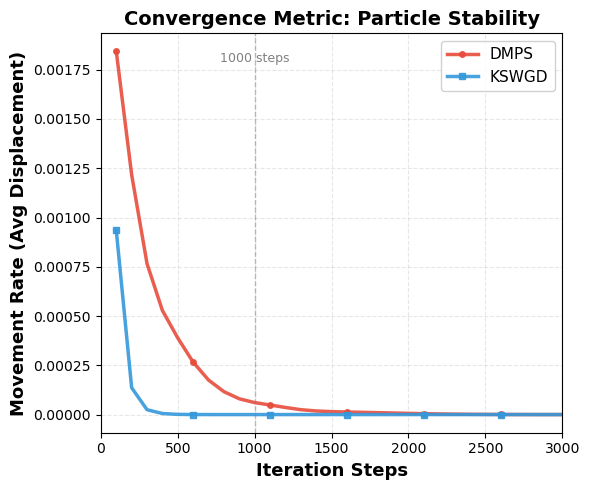


CONVERGENCE ANALYSIS SUMMARY

 AT 1000 STEPS:
----------------------------------------------------------------------

DMPS:
  • Well Coverage:    97.97%
  • Avg Potential:    0.0608
  • Movement Rate:    0.000061

Koopman(SDMD):
  • Well Coverage:    100.00%
  • Avg Potential:    0.0946
  • Movement Rate:    0.000000

 AT 3000 STEPS (FINAL):
----------------------------------------------------------------------

DMPS:
  • Well Coverage:    100.00%
  • Avg Potential:    0.0367
  • Movement Rate:    0.000000

Koopman(SDMD):
  • Well Coverage:    100.00%
  • Avg Potential:    0.0946
  • Movement Rate:    0.000000

CONVERGENCE DETECTION

Criteria: Coverage ≥ 95.0% AND Movement ≤ 0.01
----------------------------------------------------------------------

DMPS converged at step: 700
  • Well Coverage:    95.07%
  • Movement Rate:    0.000175

Koopman(SDMD) converged at step: 200
  • Well Coverage:    99.13%
  • Movement Rate:    0.000136


In [30]:
# ============================================================
# Convergence Comparison Visualization: Plot 3 - Movement Rate
# ============================================================

fig, ax3 = plt.subplots(1, 1, figsize=(6, 5))

# Color scheme
color_dm = '#E74C3C'      # Red for DMPS
color_sdmd = '#3498DB'    # Blue for Koopman(SDMD)

# ========== Plot 3: Movement Rate (Displacement per Step) ==========

ax3.plot(metrics_dm['steps'][1:], metrics_dm['movement_rate'][1:],  # Skip step 0 (movement=0)
         color=color_dm, linewidth=2.5, marker='o', markersize=4, 
         markevery=5, label='DMPS', alpha=0.9)

ax3.plot(metrics_sdmd['steps'][1:], metrics_sdmd['movement_rate'][1:], 
         color=color_sdmd, linewidth=2.5, marker='s', markersize=4, 
         markevery=5, label='KSWGD', alpha=0.9)

# Mark 1000 steps
ax3.axvline(x=1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax3.text(1000, ax3.get_ylim()[1] * 0.95, '1000 steps', 
         ha='center', va='top', fontsize=9, color='gray')

ax3.set_xlabel('Iteration Steps', fontsize=13, fontweight='bold')
ax3.set_ylabel('Movement Rate (Avg Displacement)', fontsize=13, fontweight='bold')
ax3.set_title('Convergence Metric: Particle Stability', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 3000)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(loc='upper right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# ============================================================
# Print Convergence Analysis Summary
# ============================================================

print("\n" + "="*70)
print("CONVERGENCE ANALYSIS SUMMARY")
print("="*70)

print("\n AT 1000 STEPS:")
print("-" * 70)
idx_1000 = 10  # Step 1000 is at index 10 (0, 100, 200, ..., 1000)

print(f"\nDMPS:")
print(f"  • Well Coverage:    {metrics_dm['well_coverage'][idx_1000]:.2f}%")
print(f"  • Avg Potential:    {metrics_dm['avg_potential'][idx_1000]:.4f}")
print(f"  • Movement Rate:    {metrics_dm['movement_rate'][idx_1000]:.6f}")

print(f"\nKoopman(SDMD):")
print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][idx_1000]:.2f}%")
print(f"  • Avg Potential:    {metrics_sdmd['avg_potential'][idx_1000]:.4f}")
print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][idx_1000]:.6f}")

print("\n AT 3000 STEPS (FINAL):")
print("-" * 70)

print(f"\nDMPS:")
print(f"  • Well Coverage:    {metrics_dm['well_coverage'][-1]:.2f}%")
print(f"  • Avg Potential:    {metrics_dm['avg_potential'][-1]:.4f}")
print(f"  • Movement Rate:    {metrics_dm['movement_rate'][-1]:.6f}")

print(f"\nKoopman(SDMD):")
print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][-1]:.2f}%")
print(f"  • Avg Potential:    {metrics_sdmd['avg_potential'][-1]:.4f}")
print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][-1]:.6f}")

# ============================================================
# Convergence Detection
# ============================================================

print("\n" + "="*70)
print("CONVERGENCE DETECTION")
print("="*70)

# Define convergence criteria
coverage_threshold = 95.0  # 95% particles in wells
movement_threshold = 0.01  # Very small movement

def detect_convergence(metrics_dict, coverage_thresh=95.0, movement_thresh=0.01):
    """Detect first step where convergence criteria are met"""
    steps = metrics_dict['steps']
    coverage = metrics_dict['well_coverage']
    movement = metrics_dict['movement_rate']
    
    for i in range(1, len(steps)):  # Start from 1 to skip initial step
        if coverage[i] >= coverage_thresh and movement[i] <= movement_thresh:
            return steps[i], i
    return None, None

conv_step_dm, conv_idx_dm = detect_convergence(metrics_dm, coverage_threshold, movement_threshold)
conv_step_sdmd, conv_idx_sdmd = detect_convergence(metrics_sdmd, coverage_threshold, movement_threshold)

print(f"\nCriteria: Coverage ≥ {coverage_threshold}% AND Movement ≤ {movement_threshold}")
print("-" * 70)

if conv_step_dm is not None:
    print(f"\nDMPS converged at step: {conv_step_dm}")
    print(f"  • Well Coverage:    {metrics_dm['well_coverage'][conv_idx_dm]:.2f}%")
    print(f"  • Movement Rate:    {metrics_dm['movement_rate'][conv_idx_dm]:.6f}")
else:
    print(f"\nDMPS: NOT fully converged by step 3000")
    print(f"  • Final Coverage:   {metrics_dm['well_coverage'][-1]:.2f}% (target: ≥{coverage_threshold}%)")
    print(f"  • Final Movement:   {metrics_dm['movement_rate'][-1]:.6f} (target: ≤{movement_threshold})")

if conv_step_sdmd is not None:
    print(f"\nKoopman(SDMD) converged at step: {conv_step_sdmd}")
    print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][conv_idx_sdmd]:.2f}%")
    print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][conv_idx_sdmd]:.6f}")
else:
    print(f"\nKoopman(SDMD): NOT fully converged by step 3000")
    print(f"  • Final Coverage:   {metrics_sdmd['well_coverage'][-1]:.2f}% (target: ≥{coverage_threshold}%)")
    print(f"  • Final Movement:   {metrics_sdmd['movement_rate'][-1]:.6f} (target: ≤{movement_threshold})")
